## PART I

#### DOMAIN: Automobile
#### CONTEXT: The data concerns city-cycle fuel consumption in miles per gallon, to be predicted in terms of 3 multivalued discrete and 5 continuous attributes

#### DATA DESCRIPTION: The data concerns city-cycle fuel consumption in miles per gallon
##### Attribute Information:
1. mpg: continuous
2. cylinders: multi-valued discrete
3. displacement: continuous
4. horsepower: continuous
5. weight: continuous
6. acceleration: continuous
7. model year: multi-valued discrete
8. origin: multi-valued discrete
9. car name: string (unique for each instance)

#### PROJECT OBJECTIVE: Goal is to cluster the data and treat them as individual datasets to train Regression models to predict ‘mpg’

### Step1 : import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib

from scipy import stats
from sklearn.impute import KNNImputer
from scipy.stats import mannwhitneyu, ttest_ind,levene
from sklearn.model_selection import train_test_split # Sklearn package's randomized data splitting function

from scipy.stats import zscore
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC
pd.set_option('float_format', '{:.3f}'.format)
# np.set_printoptions(suppress=True)

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

### Step 2 :  Import and warehouse data

In [2]:
#read json file
car_json_file = ('Part1 - Car-Attributes.json')
car_json_data = pd.read_json(car_json_file ,convert_dates=True)
#check shape
car_json_data.shape

(398, 8)

In [3]:
#read csv file
car_csv=pd.read_csv('Part1 - Car name.csv')
car_csv.shape

(398, 1)

In [4]:
#concat both files vertically
car_mpg=pd.concat([car_json_data,car_csv], axis=1)
car_mpg.to_csv('auto_mpg.csv', index=False)
car_mpg.shape

(398, 9)

In [5]:
def data_understand(filename):
    file = pathlib.Path(filename)
    if file.exists ():
        print ("File exist")
        print('*****************************')
        data_out=pd.read_csv(filename)
        print('ínformation of data')
        print(data_out.info())
        print('*****************************')
        print('Sample data')
        print(data_out.head())
        print('*****************************')
        print('Checking for null')
        print(data_out.isnull().sum())
    else:
        print ("File not exist")
    return data_out

def data_explore(data):
    print('Summary Statistics')
    print(data.describe(include='all'))
    print('*****************************')
    print('Checking variable skewness')
    print(data.skew())
    return None

#visualization
def univariate_vis(data):
    for i in data.columns:
        if data[i].dtypes=='int64' or data[i].dtypes=='float64':
            print('Distribution plot of',i)
            sns.kdeplot(data[i])
            plt.show()
        elif data[i].dtypes=='object':
            print('Normalize count plot of',i)
            data[i].value_counts(normalize=True).plot(kind='bar')
            plt.show()
    return None

#visualization
def multivariate_vis(data):
    sns.pairplot(data,diag_kind='kde',corner=True)
    plt.show()
    plt.figure(figsize=(20,8))
    sns.heatmap(data.corr(),cmap="YlGnBu", annot=True, annot_kws={"fontsize":9})
    plt.show()
    return None

In [6]:
data_part_1=data_understand('auto_mpg.csv')

File exist
*****************************
ínformation of data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   mpg       398 non-null    float64
 1   cyl       398 non-null    int64  
 2   disp      398 non-null    float64
 3   hp        398 non-null    object 
 4   wt        398 non-null    int64  
 5   acc       398 non-null    float64
 6   yr        398 non-null    int64  
 7   origin    398 non-null    int64  
 8   car_name  398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB
None
*****************************
Sample data
     mpg  cyl    disp   hp    wt    acc  yr  origin                   car_name
0 18.000    8 307.000  130  3504 12.000  70       1  chevrolet chevelle malibu
1 15.000    8 350.000  165  3693 11.500  70       1          buick skylark 320
2 18.000    8 318.000  150  3436 11.000  70       1        

### Summary:

1. Data has 398 observations with non-missing data
2. All the variables are integer or float except hp and car_name
3. Variable hp is expected to be numeric but shows data type as object. showing possibilities of nonmuric data

### Step 3: Data cleansing

In [7]:
#step1 : inspecting hp, as being a numeric column type of the variable in object,so checking for any nonnumeric occurances
temp = pd.DataFrame(data_part_1.hp.str.isdigit()) 
temp[temp['hp'] == False]

hp
32   False
126  False
330  False
336  False
354  False
374  False

In [8]:
#Checking these nonnumeric rows
non_num_rows=[32,126,330,336,354,374]
data_part_1.loc[non_num_rows]

mpg  cyl    disp hp    wt    acc  yr  origin              car_name
32  25.000    4  98.000  ?  2046 19.000  71       1            ford pinto
126 21.000    6 200.000  ?  2875 17.000  74       1         ford maverick
330 40.900    4  85.000  ?  1835 17.300  80       2  renault lecar deluxe
336 23.600    4 140.000  ?  2905 14.300  80       1    ford mustang cobra
354 34.500    4 100.000  ?  2320 15.800  81       2           renault 18i
374 23.000    4 151.000  ?  3035 20.500  82       1        amc concord dl

In [9]:
#step2 : replacing non-digit values with np.NAN
data_part_1=data_part_1.replace('?',np.NAN)
data_part_1.loc[non_num_rows]

mpg  cyl    disp   hp    wt    acc  yr  origin              car_name
32  25.000    4  98.000  NaN  2046 19.000  71       1            ford pinto
126 21.000    6 200.000  NaN  2875 17.000  74       1         ford maverick
330 40.900    4  85.000  NaN  1835 17.300  80       2  renault lecar deluxe
336 23.600    4 140.000  NaN  2905 14.300  80       1    ford mustang cobra
354 34.500    4 100.000  NaN  2320 15.800  81       2           renault 18i
374 23.000    4 151.000  NaN  3035 20.500  82       1        amc concord dl

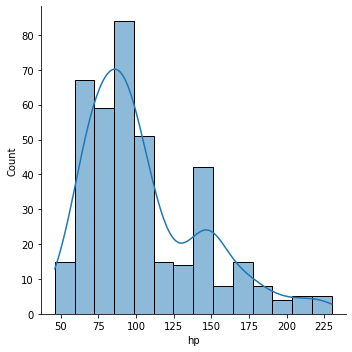

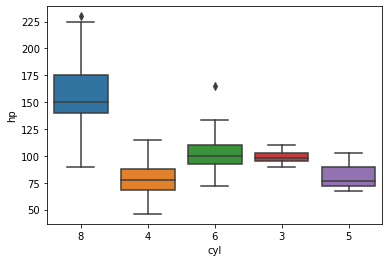

In [10]:
#Step3: checking distribution of hp
data_part_1_hp=data_part_1[~data_part_1['hp'].isnull()]

data_part_1_hp['cyl']=data_part_1_hp['cyl'].astype('str')
data_part_1_hp['hp']=data_part_1_hp['hp'].astype('int64')
sns.displot(data_part_1_hp['hp'], kde=True);
plt.show()
sns.boxplot(data_part_1_hp['cyl'],data_part_1_hp['hp']);
plt.show()


#### Summary:
1. The distribution of HP looks bimodal, with distribution changing as number of cylnders changes
2. So replacing '?' with median of data may not be correct.
3. So doing missing value imputation using K nearest neighbout imputation

## Missing value imputation

In [11]:
## Missing value imputation
data_v1=data_part_1 

imputer = KNNImputer(n_neighbors=3)

data_hp_v1=data_v1.drop('car_name', axis=1) #dropping carname

tranform=imputer.fit_transform(data_hp_v1)

#since hp is integer variable and KNN produces float, doing round of for imputer hp values
data_impute=pd.DataFrame(np.round(tranform), columns=data_hp_v1.columns)
#checking imputed values
data_impute.loc[non_num_rows]

mpg   cyl    disp      hp       wt    acc     yr  origin
32  25.000 4.000  98.000  65.000 2046.000 19.000 71.000   1.000
126 21.000 6.000 200.000 104.000 2875.000 17.000 74.000   1.000
330 41.000 4.000  85.000  62.000 1835.000 17.000 80.000   2.000
336 24.000 4.000 140.000 108.000 2905.000 14.000 80.000   1.000
354 34.000 4.000 100.000  74.000 2320.000 16.000 81.000   2.000
374 23.000 4.000 151.000  86.000 3035.000 20.000 82.000   1.000

In [12]:
#Creation of new variables
data_impute['dispercyl'] = data_impute['disp'] / data_impute['cyl']
data_impute['powertowt'] = data_impute['hp'] / data_impute['wt']

#For eda converting categorical varible to object
data_eda=data_impute.copy()
data_eda['cyl']=data_eda['cyl'].astype('object')
data_eda['origin']=data_eda['origin'].astype('object')
data_eda['yr']=data_eda['yr'].astype('object')

In [13]:
data_explore(data_eda)

Summary Statistics
           mpg     cyl    disp      hp       wt     acc      yr  origin  \
count  398.000 398.000 398.000 398.000  398.000 398.000 398.000 398.000   
unique     nan   5.000     nan     nan      nan     nan  13.000   3.000   
top        nan   4.000     nan     nan      nan     nan  73.000   1.000   
freq       nan 204.000     nan     nan      nan     nan  40.000 249.000   
mean    23.518     nan 193.427 104.148 2970.425  15.568     nan     nan   
std      7.818     nan 104.269  38.351  846.842   2.789     nan     nan   
min      9.000     nan  68.000  46.000 1613.000   8.000     nan     nan   
25%     18.000     nan 104.250  75.000 2223.750  14.000     nan     nan   
50%     23.000     nan 148.500  92.500 2803.500  16.000     nan     nan   
75%     29.000     nan 262.000 125.000 3608.000  17.000     nan     nan   
max     47.000     nan 455.000 230.000 5140.000  25.000     nan     nan   

        dispercyl  powertowt  
count     398.000    398.000  
unique        nan 

### Summary
1. mpg: average of mpg of a car is 23 with minimum mpg of a car being 9 milage per gallon with max 47
2. cyl: cars has 5 different types of cylinders, data has maximum cars with 4 cylinders
3. disp : average displacement of cars is 193.4 with std 104. And this variable is skewed
4. hp:average horse power of a car is 104 with minimum 46HP, hp is highly skewd variable
5. Wt: data has wide varitey of cars ranging from low weight to high wehight cars, with average weight of cars being 2970 with std 847. And minimum car weight is 1613. This is moderatly skew variable
6. acc: average accleration of a car is 15.5 with standard deviation 2
7. yr: data has been collected for 13 years, where maximum observations are from year 73
8. origin: data has been collected from 3 different orgin, where maximum data has been collected from origin 1
9. dispercyl: average displacement per cycle is 33.3 with std 8.6
10. powertowt : power to weight ratio has an average of 0.03. is a skwed variable

### Step 4: Data analysis & visualization

Distribution plot of mpg


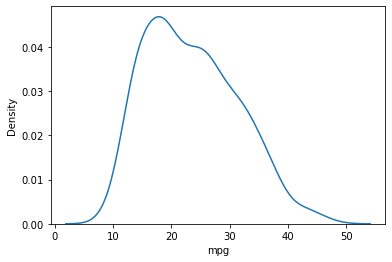

Normalize count plot of cyl


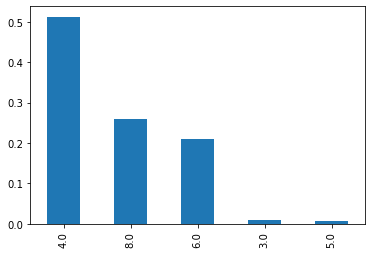

Distribution plot of disp


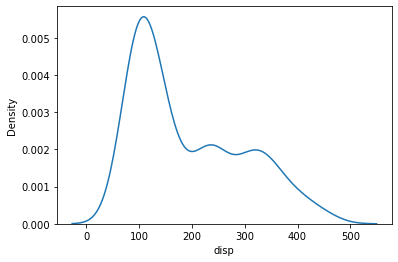

Distribution plot of hp


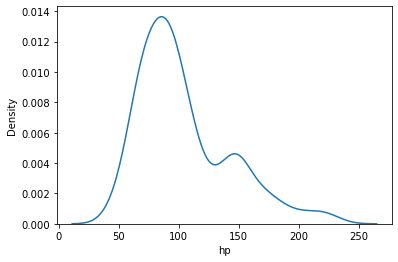

Distribution plot of wt


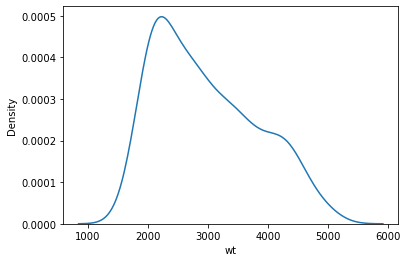

Distribution plot of acc


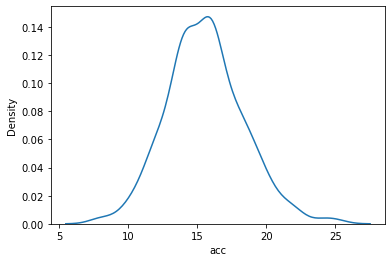

Normalize count plot of yr


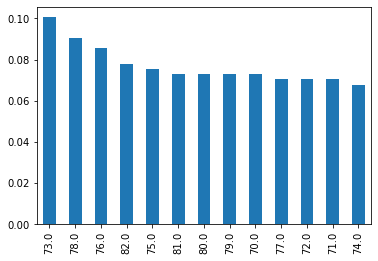

Normalize count plot of origin


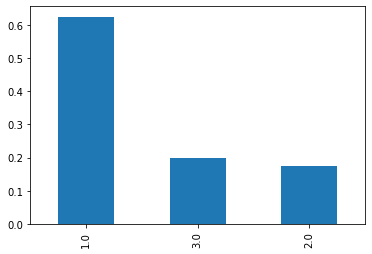

Distribution plot of dispercyl


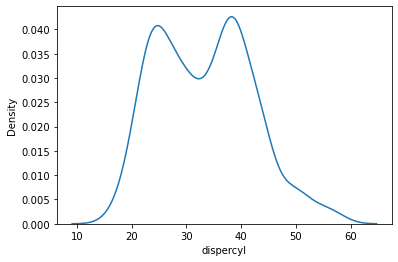

Distribution plot of powertowt


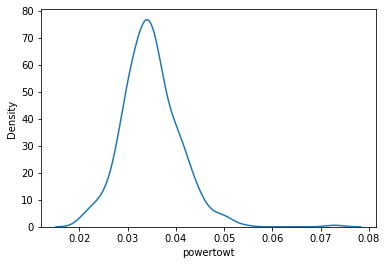

In [14]:
univariate_vis(data_eda)

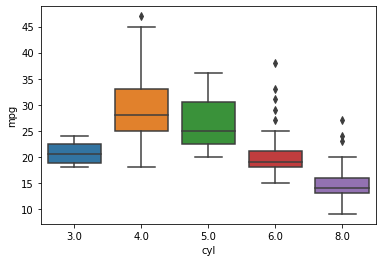

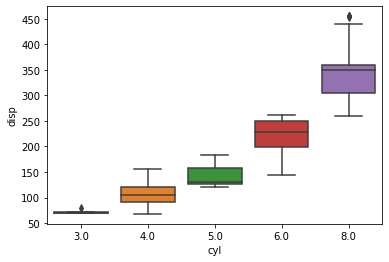

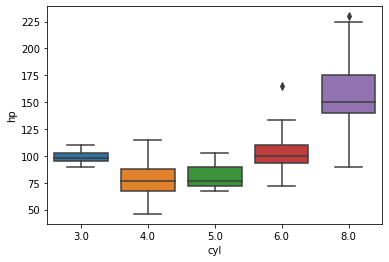

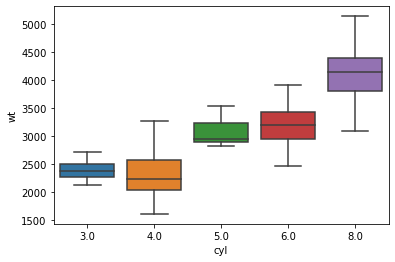

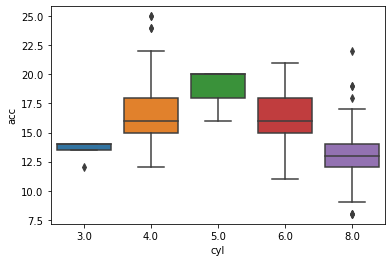

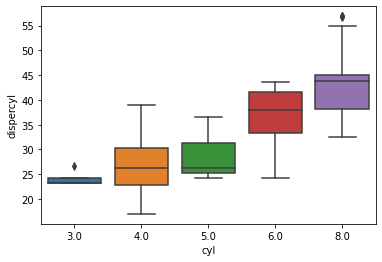

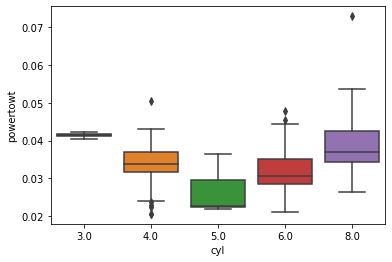

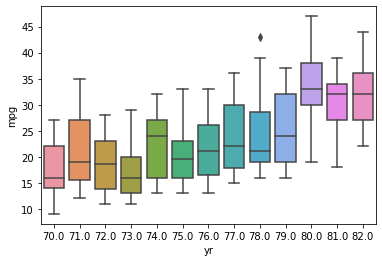

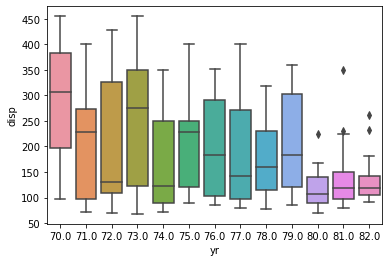

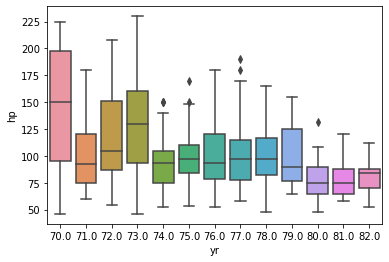

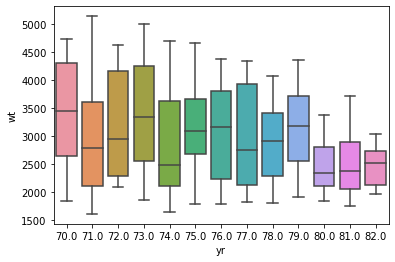

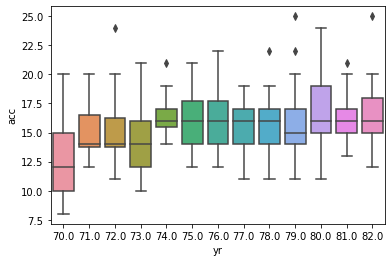

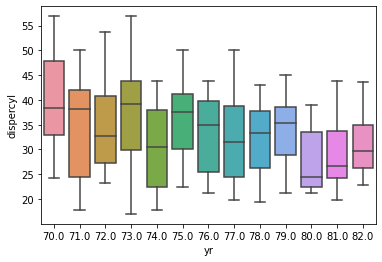

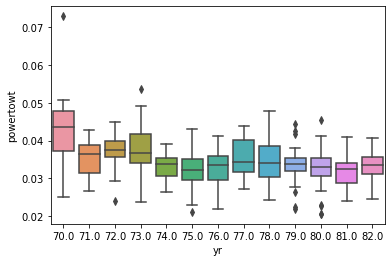

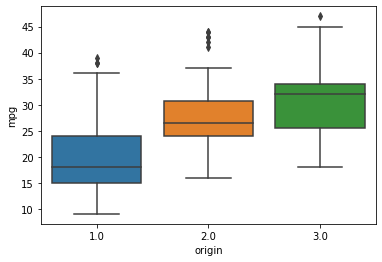

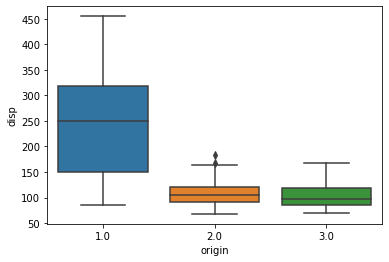

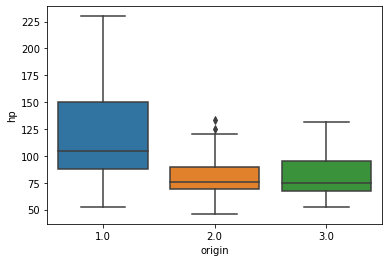

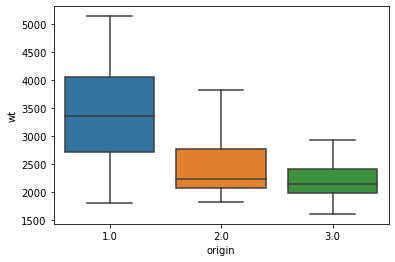

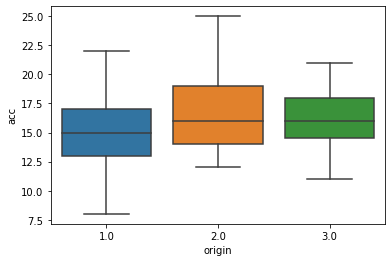

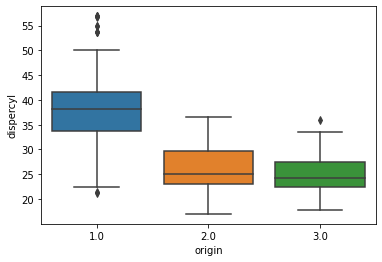

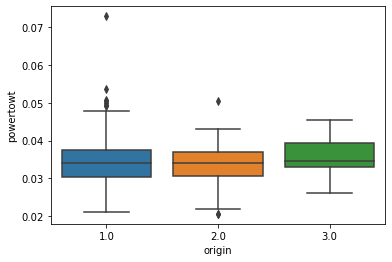

In [15]:
cat_col=['cyl','yr','origin']
data_eda_cat=data_eda[cat_col]
data_eda_num=data_eda.drop(cat_col,axis=1)

for i in data_eda_cat.columns:
    for j in data_eda_num.columns:
        sns.boxplot(data_eda_cat[i],data_eda_num[j]);
        plt.show()

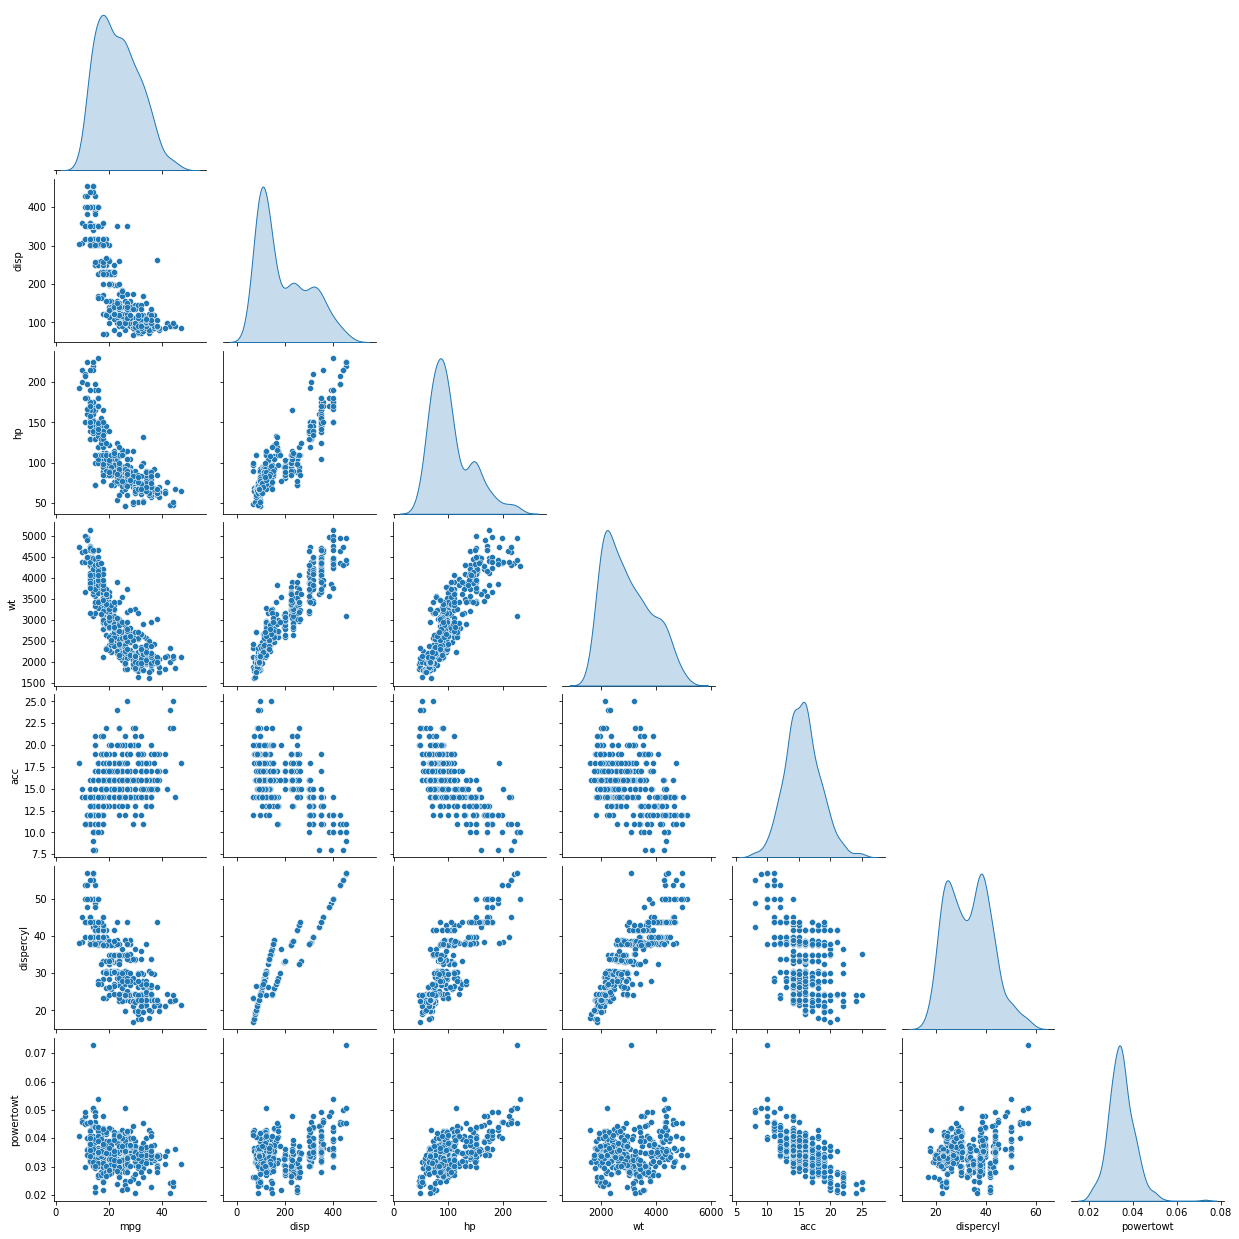

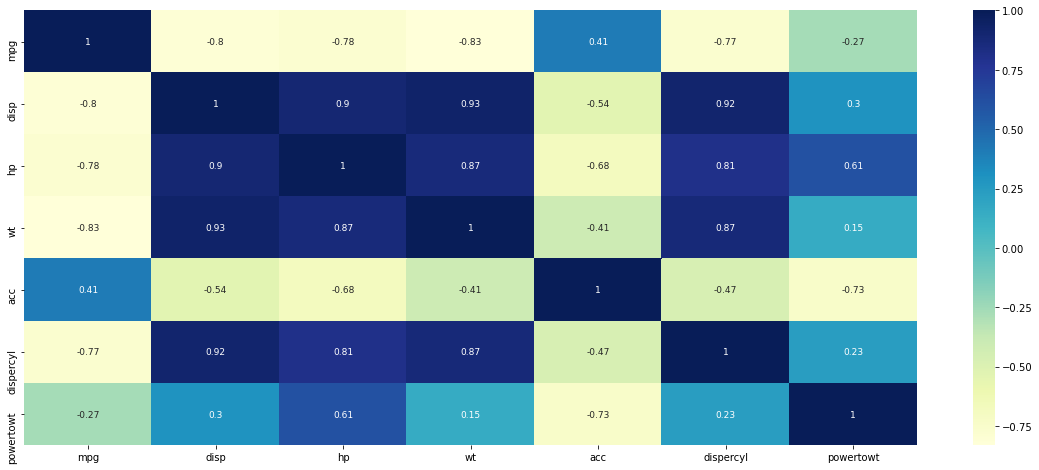

In [16]:
multivariate_vis(data_eda_num)

<AxesSubplot:xlabel='powertowt', ylabel='mpg'>

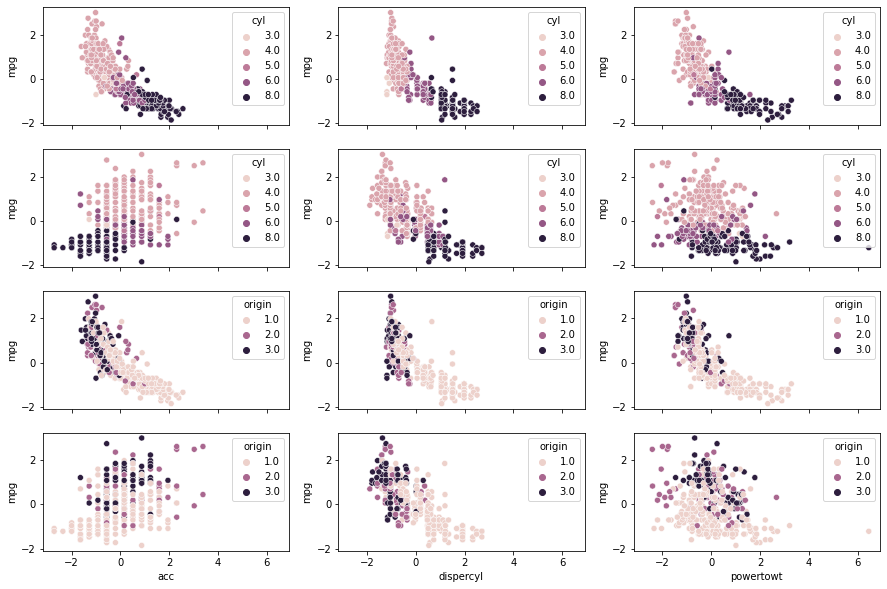

In [17]:
f, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True)
data_eda_num_z = data_eda_num.apply(zscore) ## scaled numeric columns
data_eda_num_z1 = pd.concat([data_eda_num_z,data_eda_cat], axis=1)

sns.scatterplot('wt','mpg',data=data_eda_num_z1,hue='cyl', ax=axes[0,0])
sns.scatterplot('disp','mpg',data=data_eda_num_z1,hue='cyl', ax=axes[0,1])
sns.scatterplot('hp','mpg',data=data_eda_num_z1,hue='cyl', ax=axes[0,2])
sns.scatterplot('acc','mpg',data=data_eda_num_z1,hue='cyl', ax=axes[1,0])
sns.scatterplot('dispercyl','mpg',data=data_eda_num_z1,hue='cyl', ax=axes[1,1])
sns.scatterplot('powertowt','mpg',data=data_eda_num_z1,hue='cyl', ax=axes[1,2])
sns.scatterplot('wt','mpg',data=data_eda_num_z1,hue='origin', ax=axes[2,0])
sns.scatterplot('disp','mpg',data=data_eda_num_z1,hue='origin', ax=axes[2,1])
sns.scatterplot('hp','mpg',data=data_eda_num_z1,hue='origin', ax=axes[2,2])
sns.scatterplot('acc','mpg',data=data_eda_num_z1,hue='origin', ax=axes[3,0])
sns.scatterplot('dispercyl','mpg',data=data_eda_num_z1,hue='origin', ax=axes[3,1])
sns.scatterplot('powertowt','mpg',data=data_eda_num_z1,hue='origin', ax=axes[3,2])

### Summary

1. cars displacement, hp, displacement per cycle has bimodal or multimodal distribution
2. 50% cars in this data have 4 cylinders while 8 has 25 % and 6 has 20% and there is no enough data for 3 and 5 cylinders
3. 60% data comes from origin 1 and rest comes from origin 2 and 3
4. milage changes as per cylinders in car, more the cylinders less the milage
5. displacement increases as per cylinders
6. weight of the car increases as number of cylinders increases
7. Milage shows upward trend over the years
8. Displacement, we, hp and displacement per cycle is inversely related with mpg
9. acceleration does not show any relation with mpg
10. Displacement, hp wt and displacement per cycle are also corelated with each other
11. displacement per cycle shows 3 distince lines showing possibility of 3 clusters
13. scatter plot with categorical used as hue shows possibility of 3 clusters in the data

### Step 5: Machine Learning

#### KMEANS clustering

In [18]:
from sklearn.cluster import KMeans
data_scaled=data_eda_num_z.copy()
data_scaled.describe()

mpg    disp      hp      wt     acc  dispercyl  powertowt
count 398.000 398.000 398.000 398.000 398.000    398.000    398.000
mean   -0.000   0.000   0.000  -0.000  -0.000      0.000     -0.000
std     1.001   1.001   1.001   1.001   1.001      1.001      1.001
min    -1.859  -1.204  -1.518  -1.605  -2.717     -1.886     -2.417
25%    -0.707  -0.856  -0.761  -0.883  -0.563     -1.007     -0.671
50%    -0.066  -0.431  -0.304  -0.197   0.155     -0.004     -0.103
75%     0.702   0.658   0.544   0.754   0.514      0.640      0.549
max     3.008   2.512   3.286   2.565   3.386      2.710      6.461

In [19]:
cluster_range = range( 2, 10 )   # expect 3 to four clusters from the pair panel visual inspection hence restricting from 2 to 6
cluster_errors = []
score_new=[]

for num_clusters in cluster_range:
    clusters = KMeans( num_clusters, n_init = 5)
    clusters.fit(data_scaled)
    labels = clusters.labels_
    centroids = clusters.cluster_centers_
    cluster_errors.append( clusters.inertia_ )
    score=silhouette_score(data_scaled, clusters.labels_, metric='euclidean')
    score_new.append(score)
    
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, 
                              "cluster_errors": cluster_errors,
                              "silhouette_score": score_new} )

In [20]:
clusters_df

num_clusters  cluster_errors  silhouette_score
0             2        1392.719             0.470
1             3         994.111             0.353
2             4         795.600             0.338
3             5         677.431             0.328
4             6         606.794             0.311
5             7         555.607             0.285
6             8         517.977             0.271
7             9         481.149             0.262

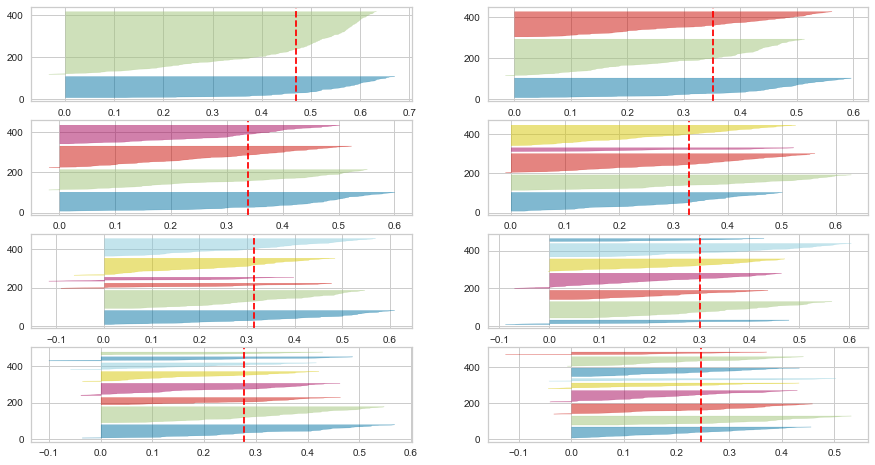

In [21]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(4, 2, figsize=(15,8))
for i in cluster_range:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(data_eda_num_z)

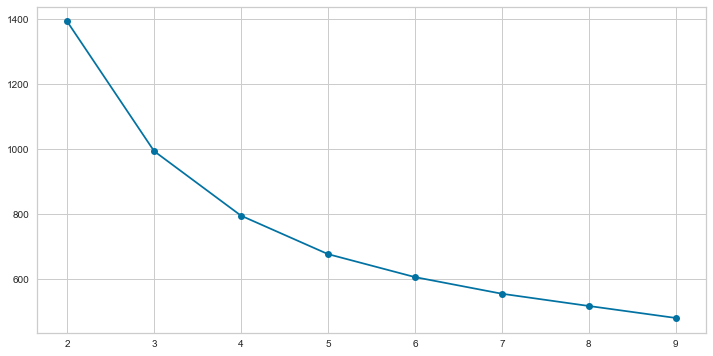

In [22]:
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

#### Summary
1. SilhouetteVisualizer, elbow plot looks like cluters 3 and 4 might be good for this data
2. SilhouetteVisualizer shows good variations within clusters 3. 
3. clusters 4 too loogs fine, but these clusters are small and might be overlapping

In [23]:
## Trying few clusters

0.47036323864450735
Groups Assigned : 

               mpg   cyl    disp       wt    acc     yr  origin
clust_group                                                    
0           26.502 4.609 141.726 2580.428 16.528 76.778   1.768
1           14.729 7.941 345.455 4117.248 12.745 73.752   1.000


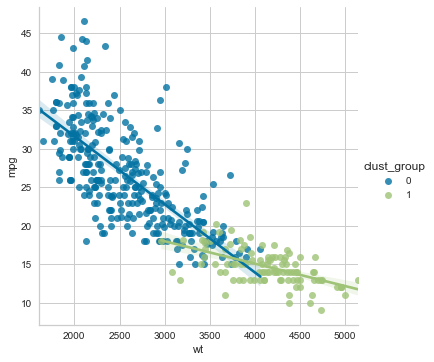

In [24]:
clusters = KMeans(2, n_init = 10)
clusters.fit(data_scaled)
x_pred_2=clusters.predict(data_scaled)
score = silhouette_score(data_scaled, clusters.labels_, metric='euclidean')

print(score)
data=data_part_1.copy()
data_clust_2=data_scaled.copy()
data_clust_2['clust_group']=x_pred_2
data['clust_group']=x_pred_2


#Append the prediction 
print("Groups Assigned : \n")
data.head()

dataClust = data.groupby(['clust_group'])
data_clust_2 = data_clust_2.groupby(['clust_group'])
print(dataClust.mean())

sns.lmplot('wt','mpg',data=data,hue='clust_group')


Summary:
1. Looks like data has been grouped into 2 clusters heavy weight car and low weight car 
2. Heavy weight cars have low mpg, more cylinders and higher displacement.
3. while less weight cars have high mpg, less cylinders and lower displacement.

0.35216552277276286
Groups Assigned : 

               mpg   cyl    disp       wt    acc     yr  origin
clust_group                                                    
0           21.023 5.455 201.130 3125.634 16.864 76.374   1.171
1           14.519 7.979 348.479 4145.865 12.628 73.604   1.000
2           30.051 4.101 104.975 2233.369 16.254 77.050   2.156
             mpg  cyl  disp   hp   wt  acc   yr  origin  car_name
clust_group                                                      
0            123  123   123  120  123  123  123     123       123
1             96   96    96   96   96   96   96      96        96
2            179  179   179  176  179  179  179     179       179


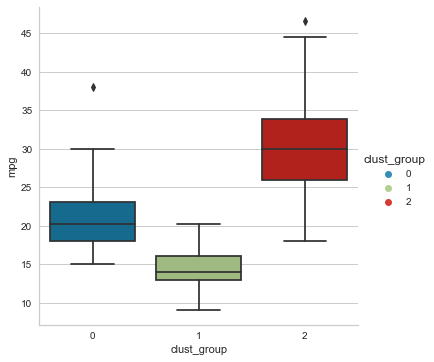

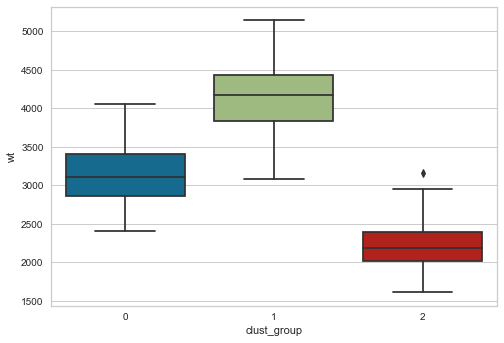

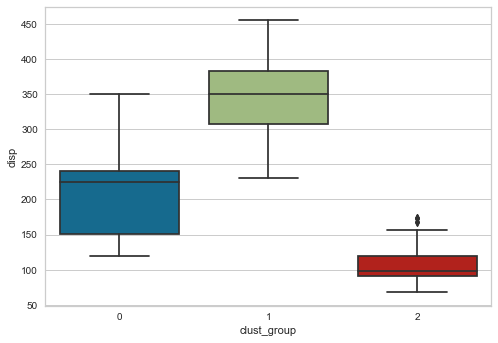

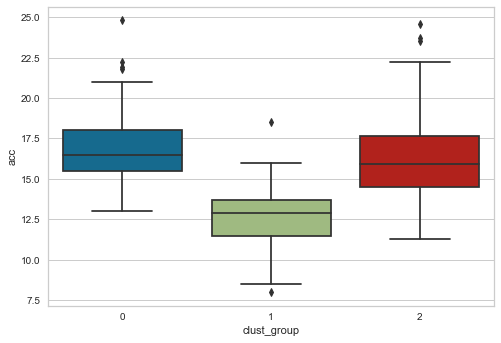

In [25]:
clusters = KMeans(3, n_init = 10)
clusters.fit(data_scaled)
kmeans_x_pred_3=clusters.predict(data_scaled)
score = silhouette_score(data_scaled, clusters.labels_, metric='euclidean')
print(score)

data=data_part_1.copy()
data_clust_3=data_scaled.copy()
data_clust_3['clust_group']=kmeans_x_pred_3
data['clust_group']=kmeans_x_pred_3


#Append the prediction 
print("Groups Assigned : \n")
data.head()

dataClust = data.groupby(['clust_group'])

print(dataClust.mean())
print(dataClust.count())

sns.lmplot('wt','mpg',data=data,hue='clust_group')

sns.boxplot('clust_group','mpg',data= data);plt.show()
sns.boxplot('clust_group','wt',data= data);plt.show()
sns.boxplot('clust_group','disp',data= data);plt.show()
sns.boxplot('clust_group','acc',data= data);plt.show()


Summary:
1. Looks like data has been grouped into 3 clusters heavy weight car and low weight car and medium weight car
2. cluster 1: Heavy weight cars have low mpg, more cylinders and higher displacement.
3. cluster 0:- light weight cars have high mpg, less cylinders and lower displacement.
4. cluster 2:- Medium weight cars have average wight more than light cars and less than heavy cars
5. All numeric parameters shows distince behaviour across 3 clusters

0.33824978371166525
Groups Assigned : 

               mpg   cyl    disp       wt    acc     yr  origin
clust_group                                                    
0           33.091 4.032  94.745 2108.702 17.682 78.191   2.234
1           14.514 7.979 348.968 4144.295 12.604 73.568   1.000
2           25.821 4.290 124.846 2461.112 14.727 76.084   1.953
3           20.652 5.637 211.441 3205.529 17.263 76.196   1.098
             mpg  cyl  disp   hp   wt  acc   yr  origin  car_name
clust_group                                                      
0             94   94    94   91   94   94   94      94        94
1             95   95    95   95   95   95   95      95        95
2            107  107   107  106  107  107  107     107       107
3            102  102   102  100  102  102  102     102       102


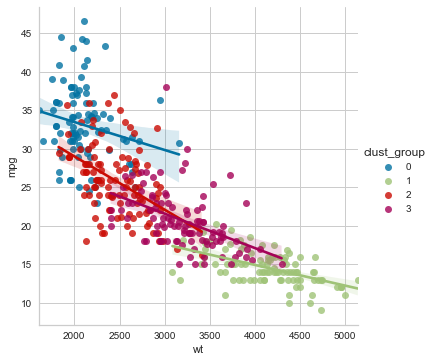

In [26]:
clusters = KMeans(4, n_init = 10)
clusters.fit(data_scaled)
x_pred_4=clusters.predict(data_scaled)
score = silhouette_score(data_scaled, clusters.labels_, metric='euclidean')
print(score)

data=data_part_1.copy()
data_clust_4=data_scaled.copy()
data_clust_4['clust_group']=x_pred_4
data['clust_group']=x_pred_4


#Append the prediction 
print("Groups Assigned : \n")
data.head()

dataClust = data.groupby(['clust_group'])
print(dataClust.mean())
print(dataClust.count())

sns.lmplot('wt','mpg',data=data,hue='clust_group')

Summary :
These lusters are overlapping and might need more data create distinct clusters

### hierarchical clustering

In [27]:
data_scaled = data_eda_num_z.copy()
data=data_part_1.copy()

          mpg   cyl    disp       wt    acc     yr  origin
labels                                                    
0      26.410 4.641 143.606 2592.239 16.511 76.777   1.757
1      14.529 7.979 348.021 4143.969 12.641 73.629   1.000
        mpg  cyl  disp   hp   wt  acc   yr  origin  car_name
labels                                                      
0       301  301   301  295  301  301  301     301       301
1        97   97    97   97   97   97   97      97        97


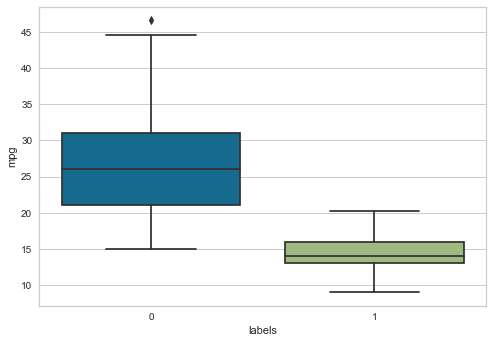

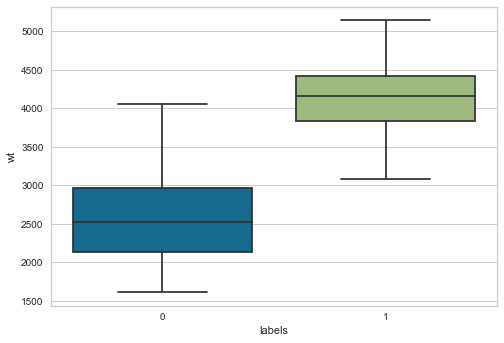

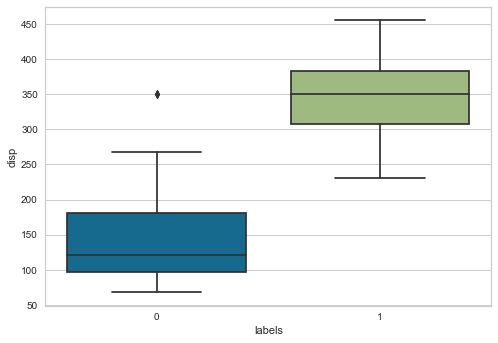

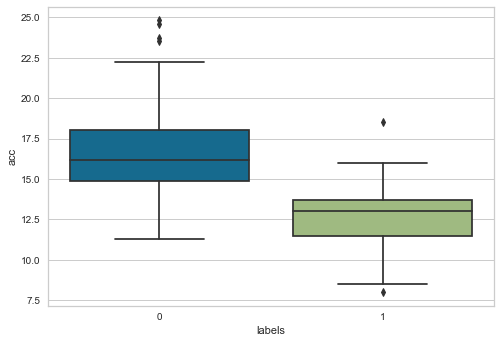

In [28]:
model = AgglomerativeClustering(n_clusters=2, affinity='euclidean')
model.fit(data_scaled)
#data=data.drop('clust_group', axis=1)
data['labels'] = model.labels_
dataClust = data.groupby(['labels'])
print(dataClust.mean())
print(dataClust.count())

sns.boxplot('labels','mpg',data= data);plt.show()
sns.boxplot('labels','wt',data= data);plt.show()
sns.boxplot('labels','disp',data= data);plt.show()
sns.boxplot('labels','acc',data= data);plt.show()

          mpg   cyl    disp       wt    acc     yr  origin
labels                                                    
0      28.269 4.246 118.385 2394.083 16.437 77.025   1.946
1      14.529 7.979 348.021 4143.969 12.641 73.629   1.000
2      19.098 6.197 242.836 3371.869 16.803 75.803   1.016
        mpg  cyl  disp   hp   wt  acc   yr  origin  car_name
labels                                                      
0       240  240   240  234  240  240  240     240       240
1        97   97    97   97   97   97   97      97        97
2        61   61    61   61   61   61   61      61        61


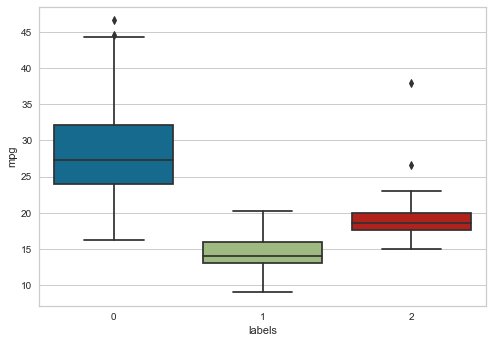

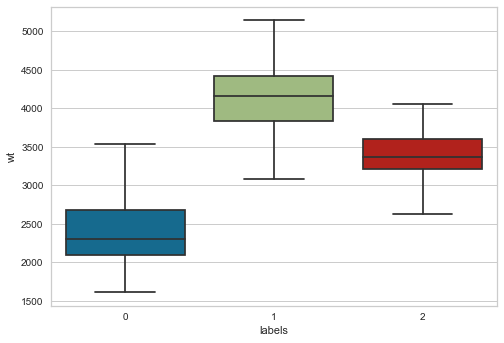

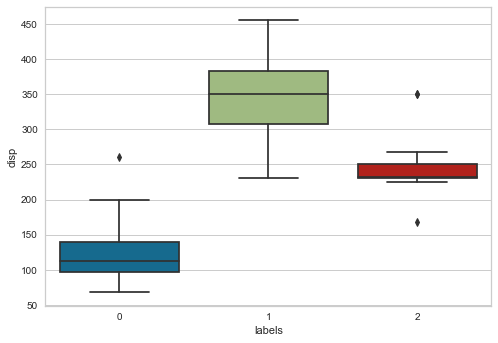

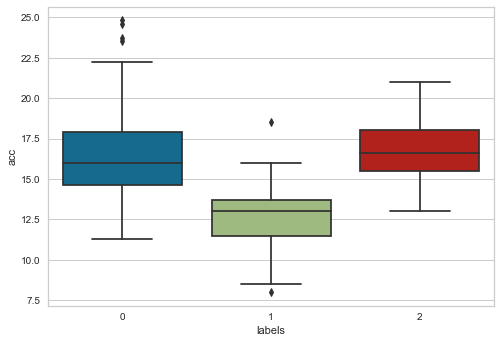

In [29]:
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean')
model.fit(data_scaled)
#data=data.drop('clust_group', axis=1)
data['labels'] = model.labels_
dataClust = data.groupby(['labels'])
print(dataClust.mean())
print(dataClust.count())

sns.boxplot('labels','mpg',data= data);plt.show()
sns.boxplot('labels','wt',data= data);plt.show()
sns.boxplot('labels','disp',data= data);plt.show()
sns.boxplot('labels','acc',data= data);plt.show()

          mpg   cyl    disp       wt    acc     yr  origin
labels                                                    
0      30.107 4.130 111.086 2307.609 17.216 77.675   1.929
1      14.529 7.979 348.021 4143.969 12.641 73.629   1.000
2      19.098 6.197 242.836 3371.869 16.803 75.803   1.016
3      23.893 4.521 135.761 2599.915 14.583 75.479   1.986
        mpg  cyl  disp   hp   wt  acc   yr  origin  car_name
labels                                                      
0       169  169   169  165  169  169  169     169       169
1        97   97    97   97   97   97   97      97        97
2        61   61    61   61   61   61   61      61        61
3        71   71    71   69   71   71   71      71        71


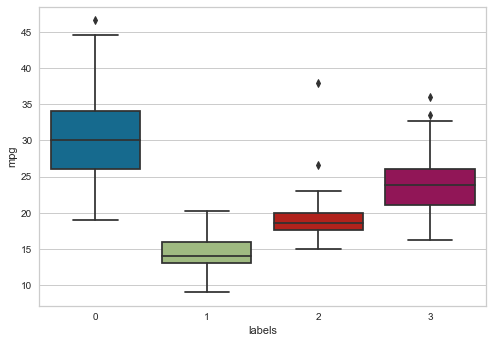

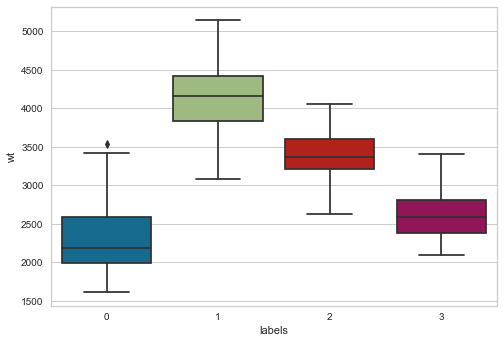

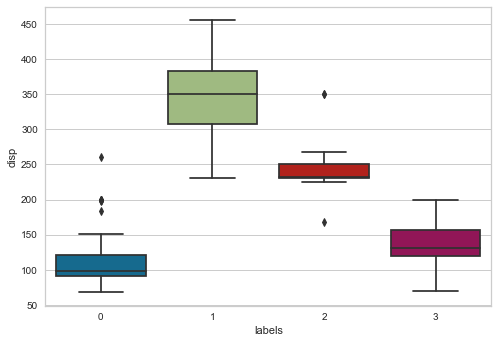

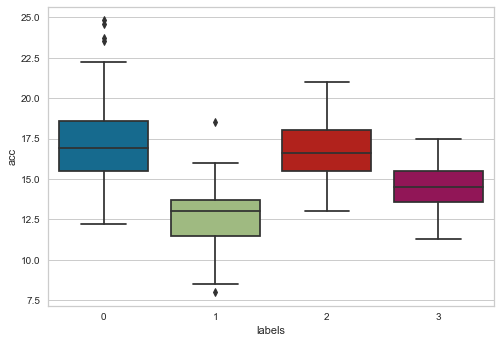

In [30]:
model = AgglomerativeClustering(n_clusters=4, affinity='euclidean')
model.fit(data_scaled)
#data=data.drop('clust_group', axis=1)
data['labels'] = model.labels_
dataClust = data.groupby(['labels'])
print(dataClust.mean())
print(dataClust.count())

sns.boxplot('labels','mpg',data= data);plt.show()
sns.boxplot('labels','wt',data= data);plt.show()
sns.boxplot('labels','disp',data= data);plt.show()
sns.boxplot('labels','acc',data= data);plt.show()

Summary:
1. based on elbow method and SilhouetteVisualizer clusters are decided.
2. looking at the elbow, SilhouetteVisualizer and data distribution across clusters it looks like cluster 3 are optimal.
3. Incase of 2 clusters, has maximum wss and from SilhouetteVisualizer it can be observed that, the cluser size varies a lot most of the data has been assigned to one cluster
4. Incase of 3 clusters there is a sudden drop in wss which gradually decreases for later clusters as per elbow and in SilhouetteVisualizer it can be observed that clusters have uniformed number of data points
4. from SilhouetteVisualizer we can see that closer clusters are formed making clusters overlapping which might lack to provide distince feature of the clusters
5. So based on above observations 3 clusters look optimal for this data
3. 3 clusters in this data devides it into light, medium and heavy weight cars
4. Also shows distribution of all paramters in this data is different.
5. by observing k-means it looks like it creates balanaced clusters
4. while hierarchical clusters have created skwed classes. as number of data points in each cluster varies a lot more than kmeans

### Regression

In [31]:
# Split X and y into training and test set in 70:30 ratio
X = data_impute.drop(['mpg','powertowt'], axis=1)
# the dependent variable
y = data_impute[['mpg']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

In [32]:
import statsmodels.api as sm

In [33]:
X_train= sm.add_constant(X_train)
model = sm.OLS(y_train,X_train)
results = model.fit()
results.params
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     188.3
Date:                Fri, 19 Feb 2021   Prob (F-statistic):          1.53e-105
Time:                        22:45:30   Log-Likelihood:                -705.82
No. Observations:                 278   AIC:                             1430.
Df Residuals:                     269   BIC:                             1462.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.6206      6.101      1.741      0.0

Dropping variables with higher p-value

In [34]:
X = data_impute.drop(['mpg','origin','acc','powertowt'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

In [35]:
X_train= sm.add_constant(X_train)
model = sm.OLS(y_train,X_train)
results = model.fit()
results.params
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     251.8
Date:                Fri, 19 Feb 2021   Prob (F-statistic):          1.02e-107
Time:                        22:45:30   Log-Likelihood:                -706.36
No. Observations:                 278   AIC:                             1427.
Df Residuals:                     271   BIC:                             1452.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.0340      5.249      1.911      0.0

After dropping variables R2 adjusted is 0.84

## Regression with clustering with 3 clusters

<AxesSubplot:>

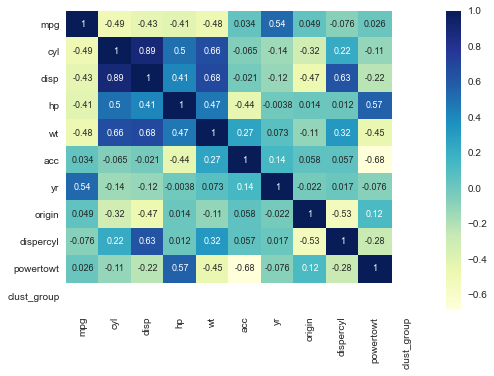

In [36]:
data_impute['clust_group']=kmeans_x_pred_3

data_clust_0_test=data_impute[data_impute['clust_group']==0]
data_clust_0_test.head(2)
sns.heatmap(data_clust_0_test.corr(),cmap="YlGnBu", annot=True, annot_kws={"fontsize":9})

In [37]:
# Split X and y into training and test set in 70:30 ratio
X = data_clust_0_test.drop(['mpg','powertowt','clust_group','origin','acc'], axis=1)
# keep_col=['wt','hp']
# X = data_clust_0_test[keep_col]
# the dependent variable
y = data_clust_0_test[['mpg']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
X_train= sm.add_constant(X_train)
model = sm.OLS(y_train,X_train)

results = model.fit()
results.params
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     19.54
Date:                Fri, 19 Feb 2021   Prob (F-statistic):           7.67e-14
Time:                        22:45:31   Log-Likelihood:                -195.72
No. Observations:                  86   AIC:                             405.4
Df Residuals:                      79   BIC:                             422.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.4896     14.561      1.132      0.2

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     12.75
Date:                Fri, 19 Feb 2021   Prob (F-statistic):           3.19e-09
Time:                        22:45:32   Log-Likelihood:                -120.71
No. Observations:                  67   AIC:                             255.4
Df Residuals:                      60   BIC:                             270.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cyl            0.2060      0.789      0.261      0.7

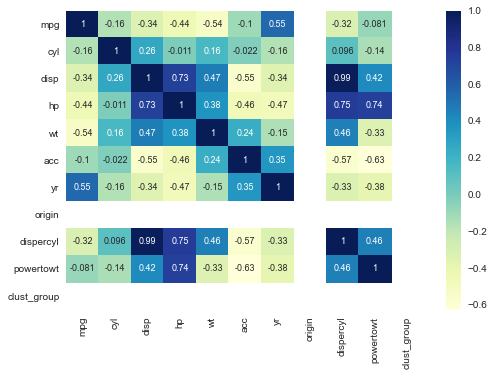

In [38]:
data_impute['clust_group']=kmeans_x_pred_3

data_clust_1_test=data_impute[data_impute['clust_group']==1]
data_clust_1_test.head(2)
sns.heatmap(data_clust_1_test.corr(),cmap="YlGnBu", annot=True, annot_kws={"fontsize":9})


# Split X and y into training and test set in 70:30 ratio
X = data_clust_1_test.drop(['mpg','powertowt','clust_group'], axis=1)
# X=data_clust_0_test[keep_col]
# the dependent variable
y = data_clust_1_test[['mpg']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
X_train= sm.add_constant(X_train)
model = sm.OLS(y_train,X_train)
results = model.fit()
results.params
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     28.57
Date:                Fri, 19 Feb 2021   Prob (F-statistic):           4.08e-24
Time:                        22:45:32   Log-Likelihood:                -326.05
No. Observations:                 125   AIC:                             670.1
Df Residuals:                     116   BIC:                             695.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -69.6002     35.013     -1.988      0.0

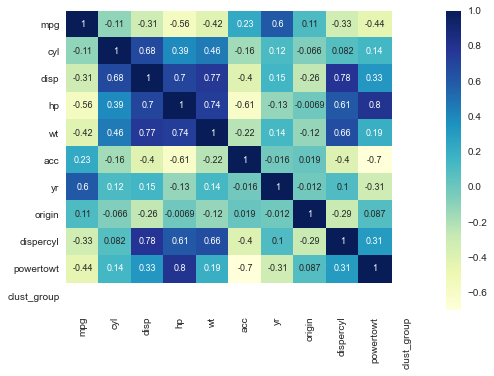

In [39]:
data_impute['clust_group']=kmeans_x_pred_3

data_clust_2_test=data_impute[data_impute['clust_group']==2]
data_clust_2_test.head(2)
sns.heatmap(data_clust_2_test.corr(),cmap="YlGnBu", annot=True, annot_kws={"fontsize":9})

# Split X and y into training and test set in 70:30 ratio
X = data_clust_2_test.drop(['mpg','powertowt','clust_group'], axis=1)
y = data_clust_2_test[['mpg']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
X_train= sm.add_constant(X_train)
model = sm.OLS(y_train,X_train)
results = model.fit()
results.params
print(results.summary())

Summary:
1. Linear regression is performaing well without clustering with adjuster Rsquar 0.84
2. Regression With 3 optimal clusters is able to explain ony 60% of hte variability.
3. after looking closer into clusters, it looks like data is becoming quite sparsed within clusters. And independent variable does not show similar relation with mpg as with whole data
4. Due to lack of data in this case Regression is not performing well within clusters


#### Data Quality recommondations
To improve the prediction, data collection needs to be improved based on various aspects as below.
1. Latest/relevant data: The time frame for this Data is year 70 to year 82. Considering the advancement in cars, the mpg prediction based on this data may not be relevant. So for mpg prediction, data should be collected from closer history like the last 5 year/10 years from data of analysis
2. Variety in data : The data is collected only on 6 parameters, the data should also include a wide variety of data like, age,maintenance of a car, regional detail, usage of a car etc. This data suffers from multicollinearity. These variables will not add much information so should try to more wide variety of data
3. Volume/quantity: With clusters we are able to understand that data is a mix of light/medium heavy weight cars. But due to lack of data within each cluster, predictions are not coming well. For a given parameter more data needs to be collected
4. Veracity:in this data we can see maximum data is collected only for 4/8/6 cylinder cars. there was no sufficient data for 3 & 5 cylinders. even the most of the data was coming from origin 1 and comparatively less from other origin. With this data is not a good representative of all the measures can add unintentional bias in the data. So for any parameters while data collection such underrepresentation of any parameters should be avoided
5. Quality: based on the data usage/ case study/business objective relevant data should be collected. with any irrelevant data with good model will not address any underline objective/questions

## PART 2

# DOMAIN: Manufacturing

#### CONTEXT: Company X curates and packages wine across various vineyards spread throughout the country.
#### DATA DESCRIPTION: The data concerns the chemical composition of the wine and its respective quality.

##### Attribute Information:
1. A, B, C, D: specific chemical composition measure of the wine
2. Quality: quality of wine [ Low and High ]

#### PROJECT OBJECTIVE: Goal is to build a synthetic data generation model using the existing data provided by the company.
#### Steps and tasks: [ Total Score: 5 points]
1. Design a synthetic data generation model which can impute values [Attribute: Quality] wherever empty the company has missed recording the data.

In [40]:
#read data
data=pd.read_excel('Part2 - Company.xlsx')
data.shape

(61, 5)

In [41]:
#understand data
data.head()

A    B    C    D    Quality
0   47   27   45  108  Quality A
1  174  133  134  166  Quality B
2  159  163  135  131        NaN
3   61   23    3   44  Quality A
4   59   60    9   68  Quality A

In [42]:
#understanding distribution of Quality
data['Quality'].value_counts(dropna=False)

Quality A    26
NaN          18
Quality B    17
Name: Quality, dtype: int64

In [43]:
data.loc[data['Quality'] == 'Quality A', 'Quality_new'] = 1  
data.loc[data['Quality'] == 'Quality B', 'Quality_new'] = 0  
data[data['Quality'].isnull()]

A    B    C    D Quality  Quality_new
2   159  163  135  131     NaN          nan
5   153  140  154  199     NaN          nan
7   191  144  143  154     NaN          nan
9   145  178  158  141     NaN          nan
14  186  142  146  174     NaN          nan
18  167  171  163  191     NaN          nan
23  171  185  181  183     NaN          nan
27  193  169  199  155     NaN          nan
29   29   49    6   35     NaN          nan
32  161  138  143  139     NaN          nan
35  181  147  174  130     NaN          nan
40  179  143  189  177     NaN          nan
46  197  173  165  197     NaN          nan
52  188  178  175  162     NaN          nan
57  137  182  165  199     NaN          nan
58   88   39    9  102     NaN          nan
59  180  157  192  198     NaN          nan
60  157  135  135  156     NaN          nan

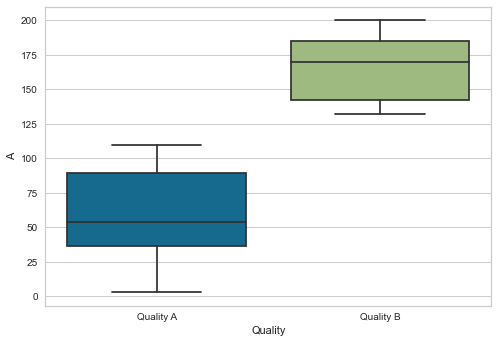

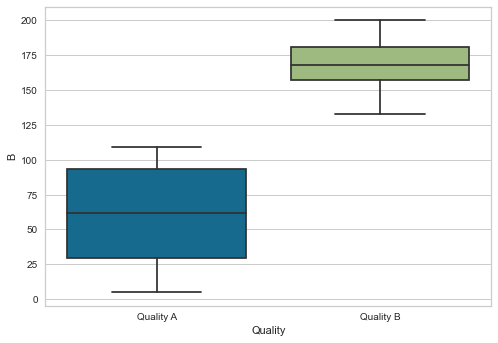

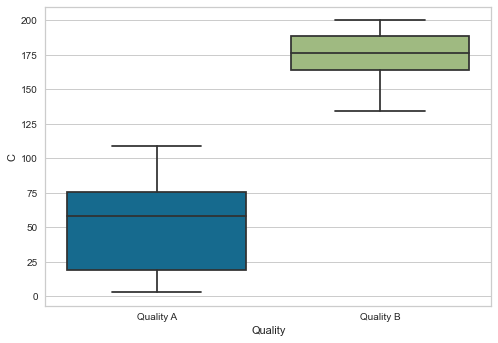

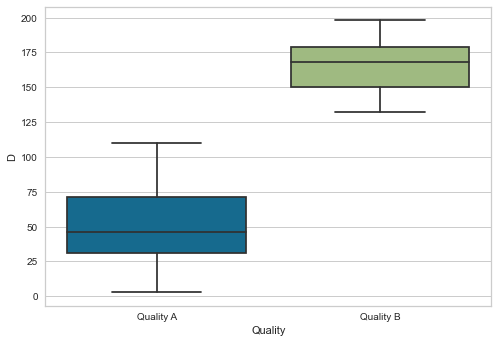

In [44]:
#understanding data
sns.boxplot(x='Quality',y='A', data=data)
plt.show()
sns.boxplot(x='Quality',y='B', data=data)
plt.show()
sns.boxplot(x='Quality',y='C', data=data)
plt.show()
sns.boxplot(x='Quality',y='D', data=data)
plt.show()

Summary:
1. distribution of all the paramters is very different for 2 qualities   

In [45]:
#data imputation
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)

data=data.drop('Quality', axis=1)
tranform=imputer.fit_transform(data)
#since hp is integer variable and KNN produces float, doing round of for imputer hp values
data_impute=pd.DataFrame(tranform, columns=data.columns)


In [46]:
non_num_rows=[2,5,7,9,58,59,60,14,18,23,27,28,32,35,40]
data_impute.loc[non_num_rows]

A       B       C       D  Quality_new
2  159.000 163.000 135.000 131.000        0.000
5  153.000 140.000 154.000 199.000        0.000
7  191.000 144.000 143.000 154.000        0.000
9  145.000 178.000 158.000 141.000        0.000
58  88.000  39.000   9.000 102.000        1.000
59 180.000 157.000 192.000 198.000        0.000
60 157.000 135.000 135.000 156.000        0.000
14 186.000 142.000 146.000 174.000        0.000
18 167.000 171.000 163.000 191.000        0.000
23 171.000 185.000 181.000 183.000        0.000
27 193.000 169.000 199.000 155.000        0.000
28  85.000  58.000  44.000  32.000        1.000
32 161.000 138.000 143.000 139.000        0.000
35 181.000 147.000 174.000 130.000        0.000
40 179.000 143.000 189.000 177.000        0.000

In [47]:
data_impute['Quality_new'].value_counts()

0.000    33
1.000    28
Name: Quality_new, dtype: int64

In [48]:
data_impute.loc[data_impute['Quality_new'] == 1, 'Quality'] = 'Quality A'  
data_impute.loc[data_impute['Quality_new'] == 0, 'Quality'] = 'Quality B' 

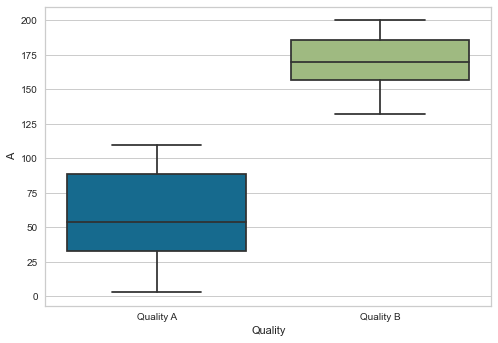

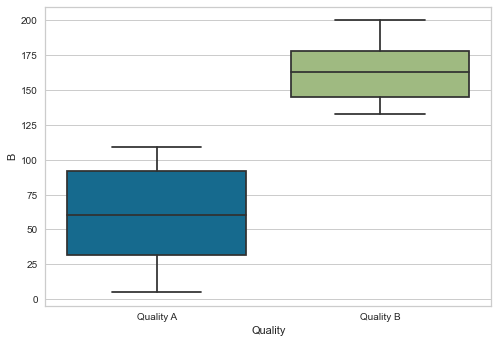

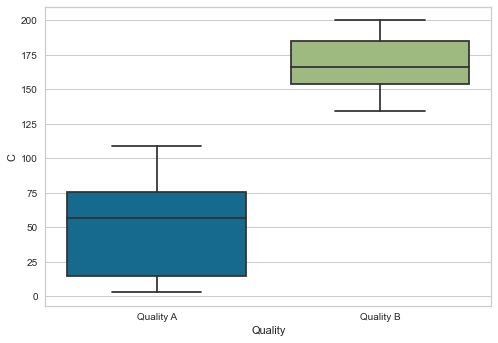

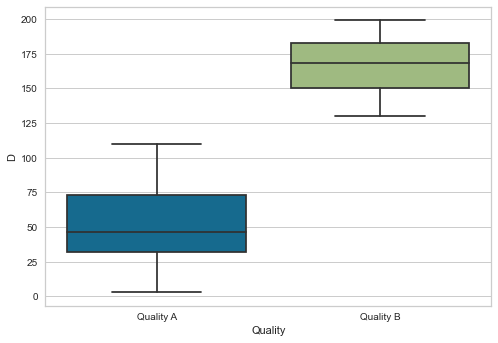

In [49]:
sns.boxplot(x='Quality',y='A', data=data_impute)
plt.show()
sns.boxplot(x='Quality',y='B', data=data_impute)
plt.show()
sns.boxplot(x='Quality',y='C', data=data_impute)
plt.show()
sns.boxplot(x='Quality',y='D', data=data_impute)
plt.show()

#### Summary:
After imputation, data distribution across quality remained same.
So imputation has not changed data distribution drastically

## PART 3

In [50]:
data_part3=data_understand(filename='Part3 - vehicle.csv')

File exist
*****************************
ínformation of data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   compactness                  846 non-null    int64  
 1   circularity                  841 non-null    float64
 2   distance_circularity         842 non-null    float64
 3   radius_ratio                 840 non-null    float64
 4   pr.axis_aspect_ratio         844 non-null    float64
 5   max.length_aspect_ratio      846 non-null    int64  
 6   scatter_ratio                845 non-null    float64
 7   elongatedness                845 non-null    float64
 8   pr.axis_rectangularity       843 non-null    float64
 9   max.length_rectangularity    846 non-null    int64  
 10  scaled_variance              843 non-null    float64
 11  scaled_variance.1            844 non-null    float64
 12  scaled_radius_of_

### Summary

1. Data has 19 columns with 846 rows
2. All variables are numeric either int64/float64 except class
3. Data has missing values across most of the variables

In [51]:
## missing data treatment
imputer=KNNImputer(n_neighbors=3,)

#drop categorical variable
#Missing data imputation
data_part3_num=data_part3.drop('class', axis=1)
transform= imputer.fit_transform(data_part3_num)
data_part3_impute_v1= pd.DataFrame(transform, columns=data_part3_num.columns)

#Create data with imputed values
keep_col=['class']
data_part3_cat=data_part3[keep_col]

data_part3_impute=pd.concat([data_part3_impute_v1,data_part3_cat], axis=1)

#data validation after imputation
data_part3_impute.info()
print(data_part3_impute.isnull().sum())
data_part3_impute.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   compactness                  846 non-null    float64
 1   circularity                  846 non-null    float64
 2   distance_circularity         846 non-null    float64
 3   radius_ratio                 846 non-null    float64
 4   pr.axis_aspect_ratio         846 non-null    float64
 5   max.length_aspect_ratio      846 non-null    float64
 6   scatter_ratio                846 non-null    float64
 7   elongatedness                846 non-null    float64
 8   pr.axis_rectangularity       846 non-null    float64
 9   max.length_rectangularity    846 non-null    float64
 10  scaled_variance              846 non-null    float64
 11  scaled_variance.1            846 non-null    float64
 12  scaled_radius_of_gyration    846 non-null    float64
 13  scaled_radius_of_gyr

compactness  circularity  distance_circularity  radius_ratio  \
780      109.000       47.000                96.000       206.000   
735       86.000       37.000                77.000       144.000   
77        86.000       40.000                62.000       140.000   
297       82.000       37.000                66.000       126.000   
710      102.000       54.000                98.000       201.000   

     pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
780                64.000                    9.000        198.000   
735                54.000                    7.000        154.000   
77                 62.000                    7.000        150.000   
297                54.000                    7.000        132.000   
710                61.000                    6.000        225.000   

     elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
780         33.000                  23.000                    150.000   
735         43.000                  19.000                    127.000   
77          45.000                  19.000                    133.000   
297         52.000                  18.000                    127.000   
710         29.000                  25.000                    165.000   

     scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
780          219.000            586.000                    191.000   
735          179.000            352.000                    145.000   
77           165.000            330.000                    173.000   
297          148.000            252.000                    142.000   
710          246.000            766.000                    231.000   

     scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
780                       70.000           4.000            13.000   
735                       71.000          14.000            13.000   
77                        79.000           2.000             3.000   
297                       72.000          17.000             7.000   
710                       79.000           9.000            14.000   

     skewness_about.2  hollows_ratio class  
780           190.000        198.000   car  
735           186.000        191.000   car  
77            180.000        185.000   car  
297           183.000        187.000   car  
710           188.000        187.000   bus

In [52]:
data_explore(data_part3_impute)

Summary Statistics
        compactness  circularity  distance_circularity  radius_ratio  \
count       846.000      846.000               846.000       846.000   
unique          nan          nan                   nan           nan   
top             nan          nan                   nan           nan   
freq            nan          nan                   nan           nan   
mean         93.678       44.864                82.097       168.968   
std           8.234        6.171                15.772        33.467   
min          73.000       33.000                40.000       104.000   
25%          87.000       40.000                70.000       141.000   
50%          93.000       44.000                80.000       167.000   
75%         100.000       49.000                98.000       195.000   
max         119.000       59.000               112.000       333.000   

        pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
count                846.000                

<AxesSubplot:>

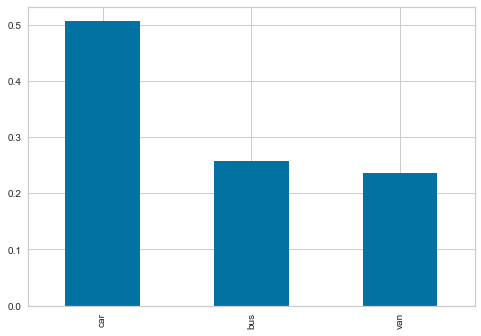

In [53]:
data_part3['class'].value_counts(normalize=True).plot(kind='bar')

### Summary:
1. Data has missing observations.
2. Taget class is imbalnced, with almost 50% data coming from class 'car' and approximately 25% each coming from 'van' and 
'bus'
3. Compatness: moderately symmetric with one outlier with average 93 and standard deviation as 8
4. Circularity:moderately symmetric with no outlier with average 44 and standard deviation as 6. And also missing data for 5 observations
5. distance_circularity:moderately symmetric with no outlier with average 82 and standard deviation as 12. And no missing data
6. radius_ratio:moderately symmetric with no outlier with average 168 and standard deviation as 33. And also missing data for 6 observations
7. pr.axis_aspect_ratio:this variable is positely skewed with average 61 and standard deviation as 7. And also missing data for 2 observations
8. max.length_aspect_ratio:this variable is positely skewed with average 8 and standard deviation as 4 and 9 outliers. And also missing data for 1 observation
9. scatter_ratio:this variable is positely skewed with average 168 and standard deviation as 33. And no missing data 
10. elongatedness:variable is not skewed with average 40 and standard deviation as 7. And no missing data
11. pr.axis_rectangularity:variable is skewed with average 20 and standard deviation as 2. 
12. max.length_rectangularity:variable is not skewed with average 147 and standard deviation as 14. 
12. Variables pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio, pr.axis_rectangularity, scaled_variance,scaled_variance.1,skewness_about,skewness_about.1 are skewed.

Distribution plot of compactness


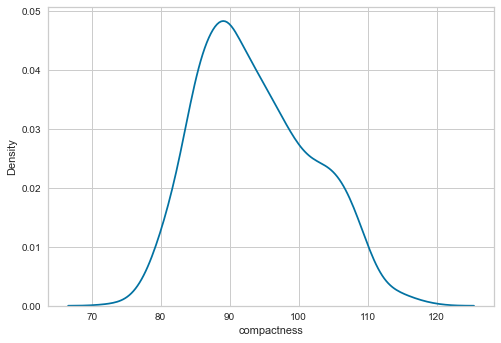

Distribution plot of circularity


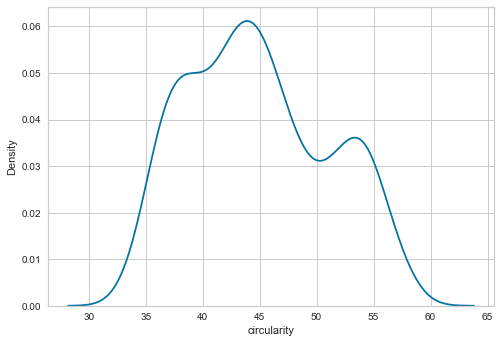

Distribution plot of distance_circularity


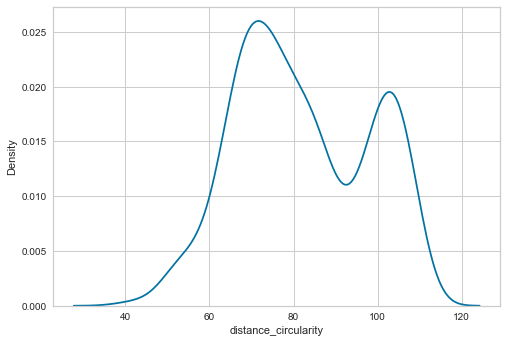

Distribution plot of radius_ratio


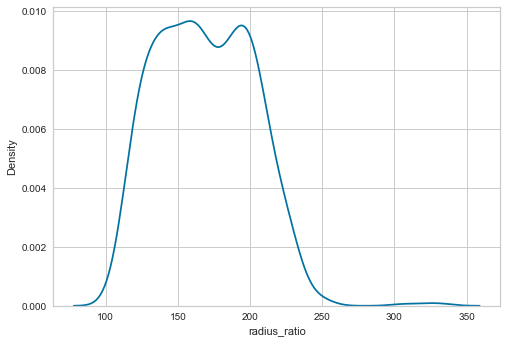

Distribution plot of pr.axis_aspect_ratio


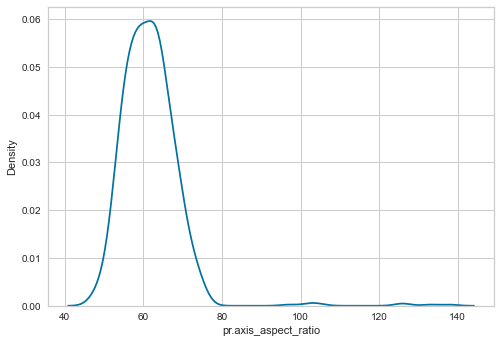

Distribution plot of max.length_aspect_ratio


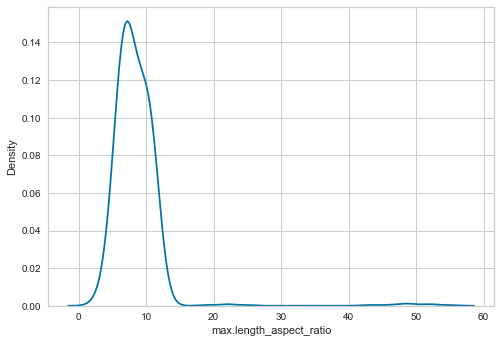

Distribution plot of scatter_ratio


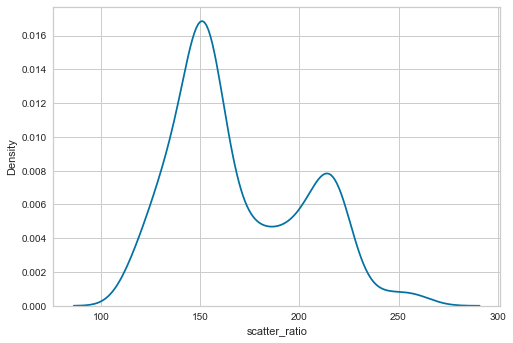

Distribution plot of elongatedness


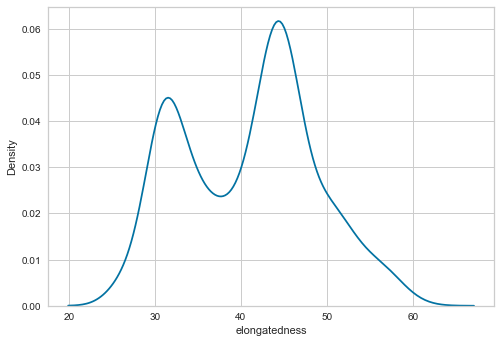

Distribution plot of pr.axis_rectangularity


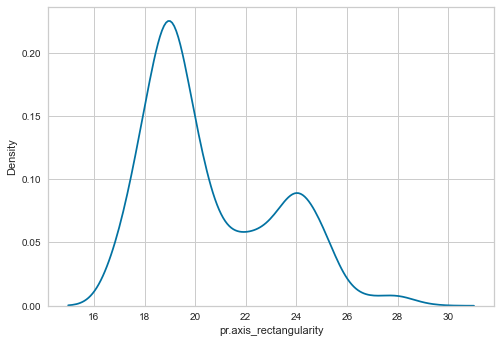

Distribution plot of max.length_rectangularity


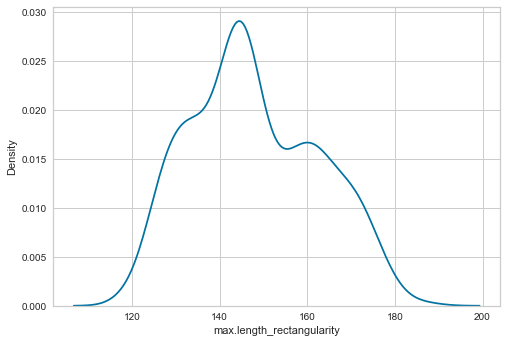

Distribution plot of scaled_variance


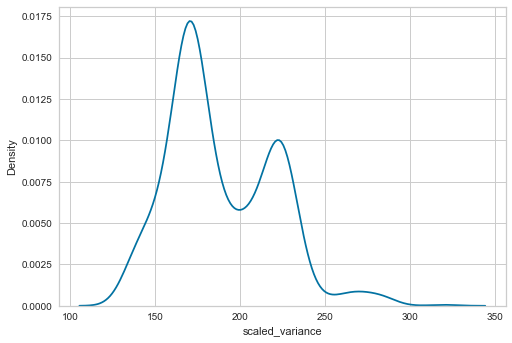

Distribution plot of scaled_variance.1


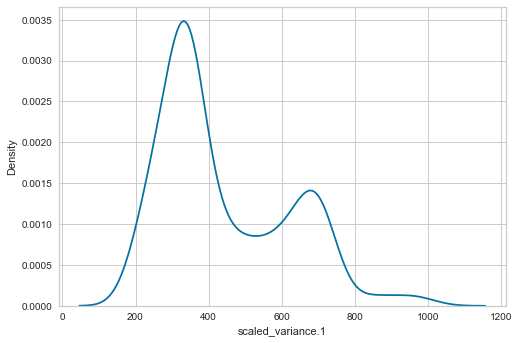

Distribution plot of scaled_radius_of_gyration


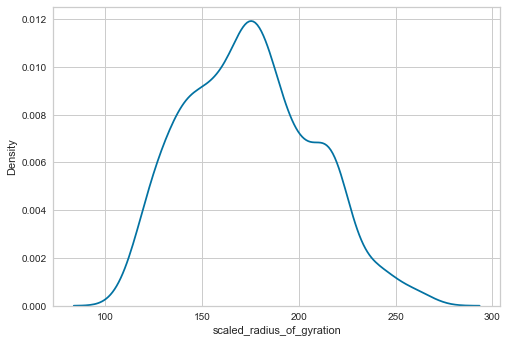

Distribution plot of scaled_radius_of_gyration.1


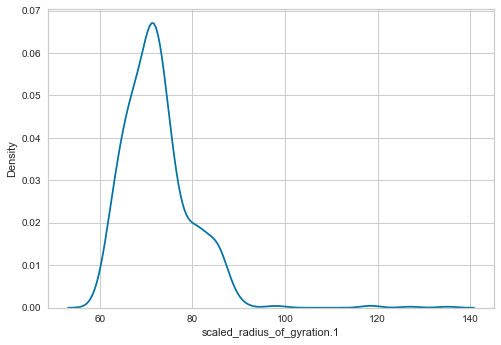

Distribution plot of skewness_about


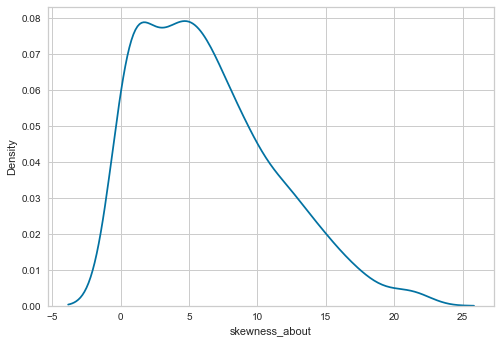

Distribution plot of skewness_about.1


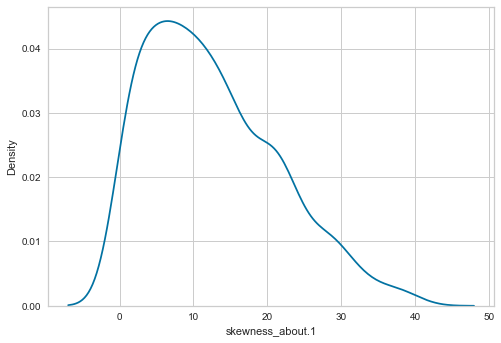

Distribution plot of skewness_about.2


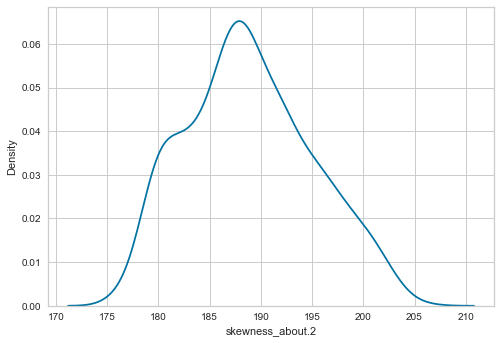

Distribution plot of hollows_ratio


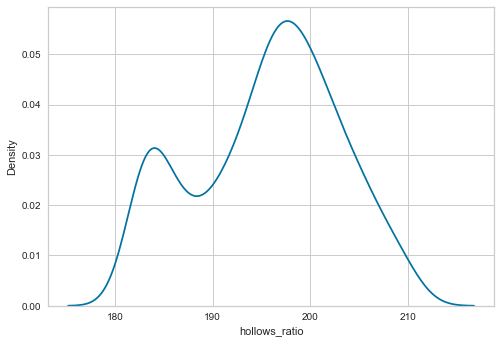

Normalize count plot of class


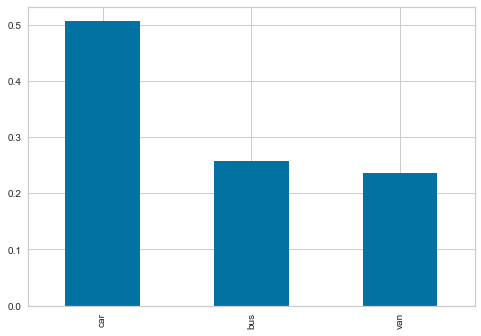

In [54]:
univariate_vis(data_part3_impute)

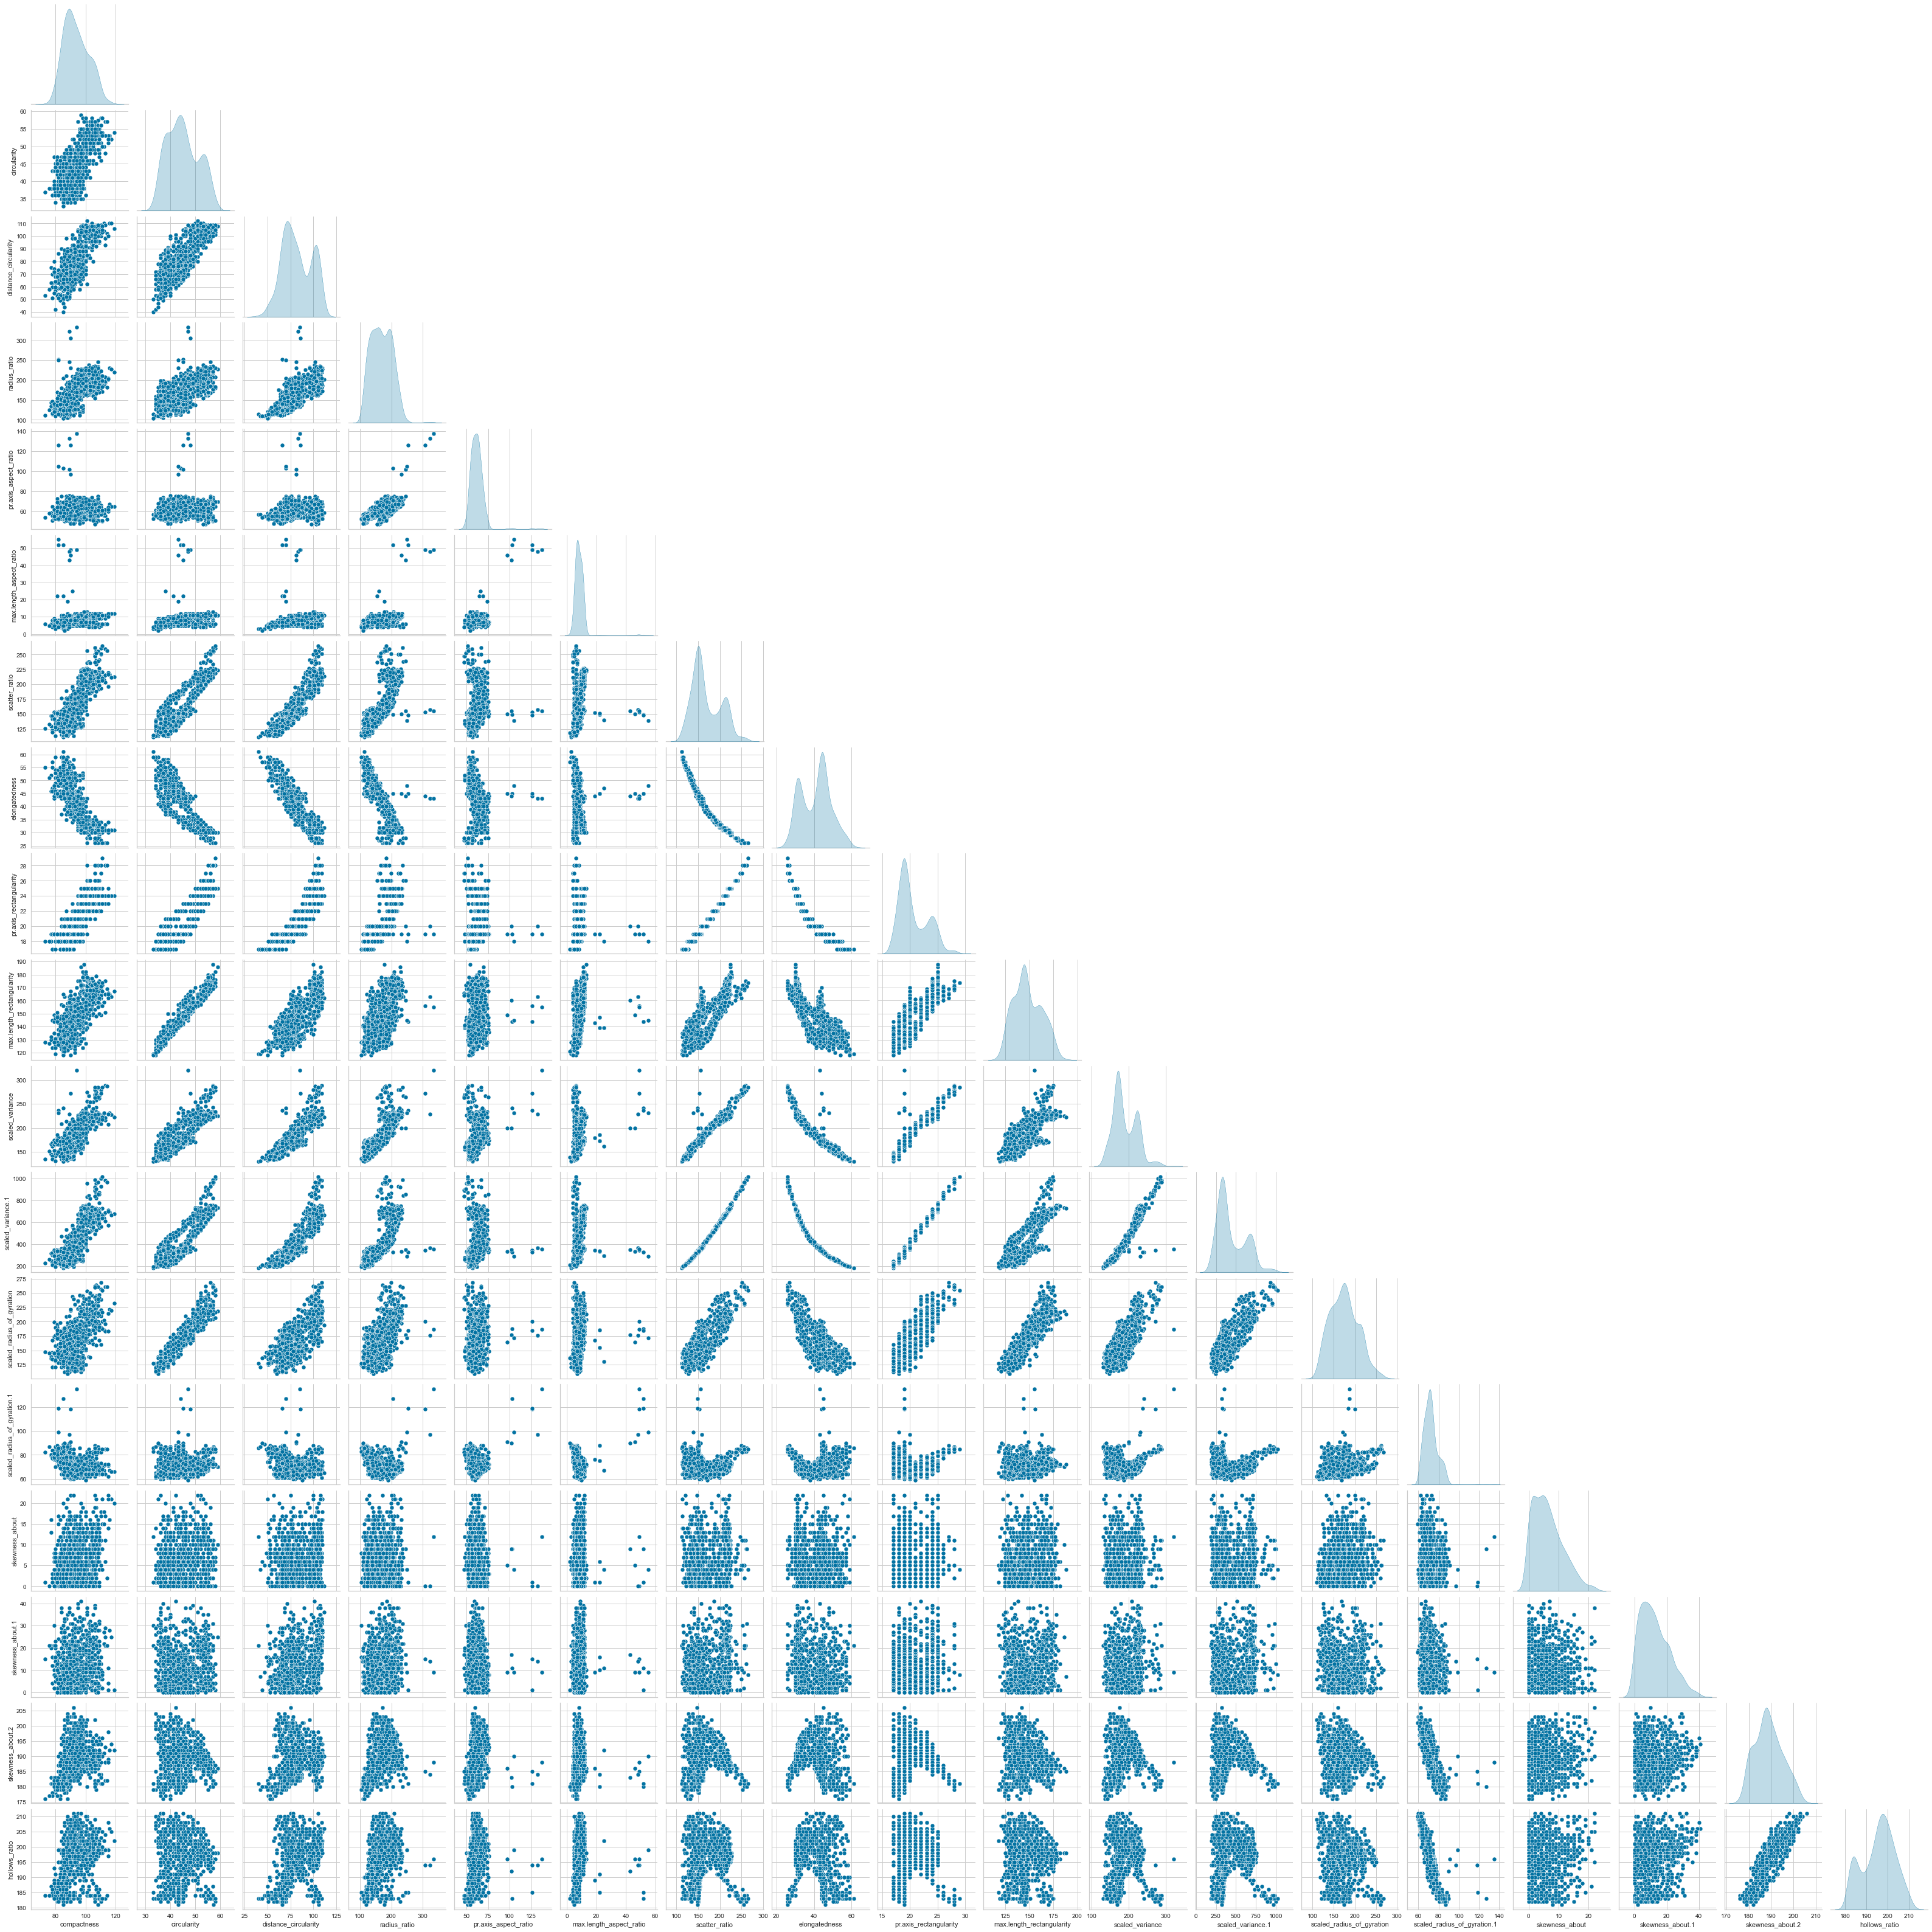

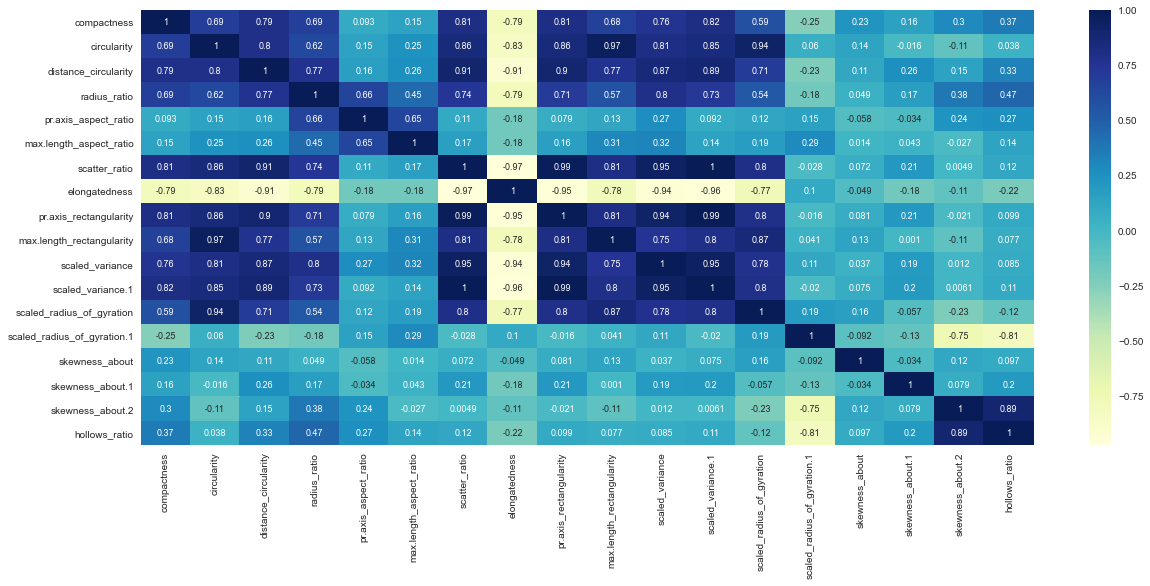

In [55]:
multivariate_vis(data_part3_impute)

Summary:
1. a lot of independent variables show bimodal/multimodal distribution.
2. Data has wide variety of skew variables
3. Correlation matrix show presence of multicollinearity within data

Scalling

In [56]:
drop_col=['class']
data_eda_cat=data_part3_impute[drop_col]

data_eda_num=data_part3_impute.drop('class', axis=1)
data_eda_num_z = data_eda_num.apply(zscore)

target_class = {"class":{"car": 1, "van": 2,"bus": 3}}
data_eda_cat = data_eda_cat.replace(target_class )

data_ana=pd.concat([data_eda_num_z,data_eda_cat], axis=1)
# # data_eda_num_z
X=data_eda_num_z
y=data_eda_cat
X.head()

compactness  circularity  distance_circularity  radius_ratio  \
0        0.161        0.509                 0.057         0.270   
1       -0.325       -0.627                 0.121        -0.836   
2        1.254        0.833                 1.516         1.197   
3       -0.082       -0.627                -0.006        -0.298   
4       -1.055       -0.140                -0.767         1.077   

   pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
0                 1.308                    0.312         -0.206   
1                -0.595                    0.094         -0.597   
2                 0.547                    0.312          1.149   
3                 0.166                    0.094         -0.748   
4                 5.241                    9.445         -0.597   

   elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
0          0.137                  -0.225                      0.758   
1          0.521                  -0.611                     -0.345   
2         -1.144                   0.933                      0.689   
3          0.649                  -0.611                     -0.345   
4          0.521                  -0.611                     -0.276   

   scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
0           -0.402             -0.345                      0.286   
1           -0.593             -0.622                     -0.514   
2            1.095              1.105                      1.392   
3           -0.912             -0.741                     -1.467   
4            1.669             -0.651                      0.409   

   scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
0                       -0.329          -0.076             0.381   
1                       -0.062           0.535             0.157   
2                        0.072           1.554            -0.403   
3                       -1.265          -0.076            -0.291   
4                        7.295           0.535            -0.179   

   skewness_about.2  hollows_ratio  
0            -0.313          0.184  
1             0.012          0.453  
2            -0.151          0.049  
3             1.637          1.529  
4            -1.451         -1.699

In [57]:
## PCA

In [58]:
covMatrix=np.cov(X,rowvar=False)
print(covMatrix) #18X18 matrix

[[ 1.00118343  0.69358813  0.79337996  0.69245673  0.09300451  0.14842463
   0.81395647 -0.78958033  0.81439967  0.67694334  0.76535933  0.81954358
   0.58585799 -0.25283844  0.2349534   0.15672688  0.29853373  0.36598446]
 [ 0.69358813  1.00118343  0.79958255  0.62398181  0.14882271  0.24755669
   0.86142998 -0.82971262  0.85897129  0.96686203  0.80959328  0.85367982
   0.93724919  0.0596494   0.14425773 -0.01602062 -0.11243479  0.03818637]
 [ 0.79337996  0.79958255  1.00118343  0.77352967  0.16083123  0.26427052
   0.90904151 -0.91394614  0.89709843  0.77579169  0.86634154  0.89143461
   0.70686285 -0.23046733  0.1132769   0.26450251  0.14820651  0.33460576]
 [ 0.69245673  0.62398181  0.77352967  1.00118343  0.66512478  0.44894256
   0.7402403  -0.79423264  0.71314471  0.57189125  0.7992602   0.72750705
   0.54052721 -0.18207672  0.04878929  0.17487009  0.38156738  0.46953934]
 [ 0.09300451  0.14882271  0.16083123  0.66512478  1.00118343  0.64893536
   0.10576004 -0.18490281  0.07957

In [59]:
pca=PCA()
pca.fit(X)
print(pca.explained_variance_)
print(pca.components_)
print(pca.explained_variance_ratio_)

[9.44003964e+00 3.02567316e+00 1.90115114e+00 1.17732080e+00
 9.18566372e-01 5.33981412e-01 3.56146761e-01 2.20532466e-01
 1.57731687e-01 9.10805146e-02 6.30820662e-02 4.39847569e-02
 3.50949393e-02 2.13539098e-02 1.59846184e-02 1.30087768e-02
 6.20171265e-03 3.67050455e-04]
[[ 2.74813186e-01  2.95033123e-01  3.04432972e-01  2.67852403e-01
   8.04450956e-02  9.67308036e-02  3.16995339e-01 -3.13584362e-01
   3.13940460e-01  2.82328652e-01  3.09425684e-01  3.14379567e-01
   2.71743395e-01 -2.10123310e-02  4.06282194e-02  5.75447619e-02
   2.93735776e-02  7.34960495e-02]
 [-1.27763839e-01  1.30151805e-01 -7.50822012e-02 -1.88610169e-01
  -1.21126529e-01  1.10952747e-02  4.69480162e-02  1.35375021e-02
   5.97968773e-02  1.15660786e-01  6.17393889e-02  5.15001314e-02
   2.08589357e-01  4.89110761e-01 -5.62352468e-02 -1.24877443e-01
  -5.40729062e-01 -5.39484014e-01]
 [-1.19337420e-01 -3.02008152e-02 -5.53526696e-02  2.74597505e-01
   6.42807833e-01  5.92027236e-01 -9.63165725e-02  5.6485992

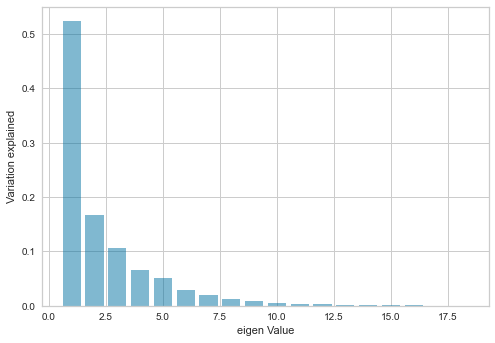

In [60]:
plt.bar(list(range(1,19)),pca.explained_variance_ratio_,alpha=0.5, align='center')
plt.ylabel('Variation explained')
plt.xlabel('eigen Value')
plt.show()

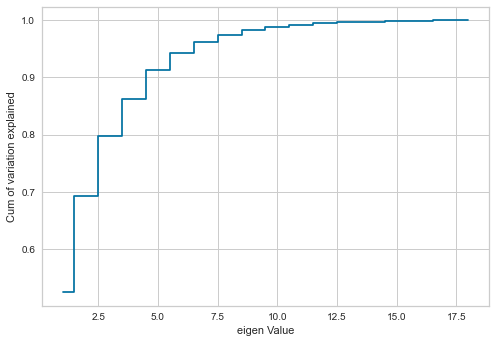

In [61]:
plt.step(list(range(1,19)),np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Cum of variation explained')
plt.xlabel('eigen Value')
plt.show()

In [62]:
# Dimensionality Reduction

In [63]:
pca5 = PCA(n_components=5)
pca5.fit(X)
print(pca5.components_)
print(pca5.explained_variance_ratio_)
Xpca5 = pca5.transform(X)

[[ 2.74813186e-01  2.95033123e-01  3.04432972e-01  2.67852403e-01
   8.04450956e-02  9.67308036e-02  3.16995339e-01 -3.13584362e-01
   3.13940460e-01  2.82328652e-01  3.09425684e-01  3.14379567e-01
   2.71743395e-01 -2.10123310e-02  4.06282194e-02  5.75447619e-02
   2.93735776e-02  7.34960495e-02]
 [-1.27763839e-01  1.30151805e-01 -7.50822012e-02 -1.88610169e-01
  -1.21126529e-01  1.10952747e-02  4.69480162e-02  1.35375021e-02
   5.97968773e-02  1.15660786e-01  6.17393889e-02  5.15001314e-02
   2.08589357e-01  4.89110761e-01 -5.62352468e-02 -1.24877443e-01
  -5.40729062e-01 -5.39484014e-01]
 [-1.19337420e-01 -3.02008152e-02 -5.53526696e-02  2.74597505e-01
   6.42807833e-01  5.92027236e-01 -9.63165725e-02  5.64859929e-02
  -1.09167474e-01 -1.70876257e-02  5.67886827e-02 -1.07779015e-01
  -3.13974299e-02  2.85084332e-01 -1.16566162e-01 -7.48136950e-02
   9.40701117e-03  4.03751691e-02]
 [ 7.90923579e-02  1.84908357e-01 -7.06317534e-02 -4.24439966e-02
   3.56215923e-02  3.14981982e-02 -9.

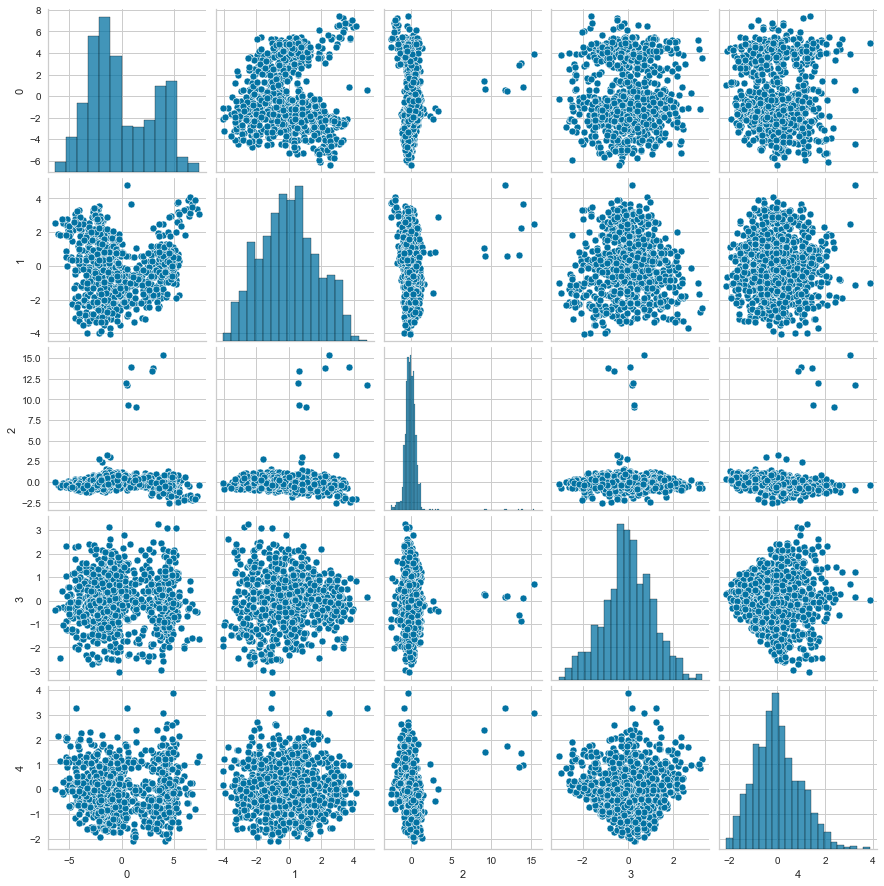

In [64]:
sns.pairplot(pd.DataFrame(Xpca5))

Summary:
PCA reduces data from 19 dimentions to 5 dimentions which explains almost 90% of the variation in the data

In [65]:
test_size = 0.30 # taking 70:30 training and test set
seed = 7  # Random numbmer seeding for reapeatability of the code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
type(X_train)

pandas.core.frame.DataFrame

In [66]:
y_train.value_counts()

class
1        302
3        152
2        138
dtype: int64

In [67]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svc = SVC()

parameters = {
              'kernel' :['poly', 'rbf', 'sigmoid'], 
              'C': [0.1, 0.4, 0.8, 1, 2, 5,10,20,30]
              }

grid_search=GridSearchCV(estimator=svc ,param_grid=parameters,cv=10,n_jobs=-1,verbose=2)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.3s


{'C': 20, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Done 255 out of 270 | elapsed:    6.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    6.7s finished


In [68]:
classifier = SVC(C=20, kernel='rbf')
classifier.fit(X_train, y_train)
y_predict=classifier.predict(X_test)
model_score = classifier.score(X_test, y_test)
model_score

0.9881889763779528

In [69]:
classifier.score(X_train, y_train)

1.0

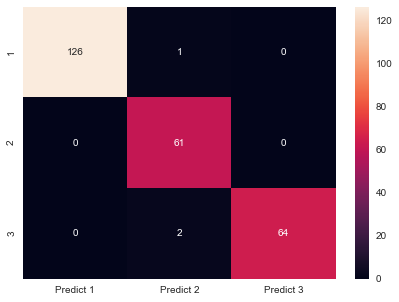

In [70]:
from sklearn import metrics
cm=metrics.confusion_matrix(y_test, y_predict, labels=[1, 2,3])
df_cm = pd.DataFrame(cm, index = [j for j in ["1","2","3"]],columns = [j for j in ["Predict 1","Predict 2","Predict 3"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True,fmt='g',annot_kws={"fontsize":10})
plt.show()

Classification with PCA

In [71]:
test_size = 0.30 # taking 70:30 training and test set
seed = 7  # Random numbmer seeding for reapeatability of the code
X_train, X_test, y_train, y_test = train_test_split(Xpca5, y, test_size=test_size, random_state=seed)

In [72]:
classifier = SVC(C=20, kernel='rbf')
classifier.fit(X_train, y_train)
y_predict=classifier.predict(X_test)
model_score = classifier.score(X_test, y_test)
model_score

0.8228346456692913

In [73]:
classifier.score(X_train, y_train)

0.8817567567567568

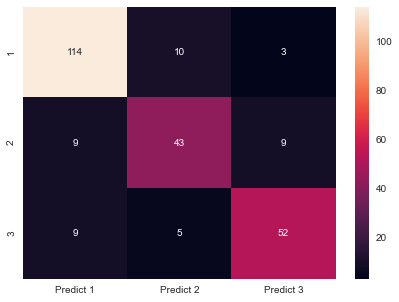

In [74]:
from sklearn import metrics
cm=metrics.confusion_matrix(y_test, y_predict, labels=[1, 2,3])
df_cm = pd.DataFrame(cm, index = [j for j in ["1","2","3"]],columns = [j for j in ["Predict 1","Predict 2","Predict 3"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True,fmt='g',annot_kws={"fontsize":10})
plt.show()

Summary:
1. infirst case without the pca model overfits data.
2. Independent variables in this data show multicollinearity. with pca we get all independent components.
3. with pca,svm does not overfit this data

## Part 4

### DOMAIN: Sports management
### CONTEXT: Company X is a sports management company for international cricket.
### DATA DESCRIPTION: The data is collected belongs to batsman from IPL series conducted so far. Attribute Information:
1. Runs: Runs score by the batsman
2. Ave: Average runs scored by the batsman per match
3. SR: strike rate of the batsman
4. Fours: number of boundary/four scored
5. Six: number of boundary/six scored
6. HF: number of half centuries scored so far
### PROJECT OBJECTIVE: 
#### Goal is to build a data driven batsman ranking model for the sports management company to make business decisions.

1. EDA and visualisation: Create a detailed performance report using univariate, bi-variate and multivariate EDA techniques. Find out all possible hidden patterns by using all possible methods.
2. Build a data driven model to rank all the players in the dataset using all or the most important performance features.

In [75]:
data_4=data_understand(filename='Part4 - batting_bowling_ipl_bat.csv')

File exist
*****************************
ínformation of data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Name    90 non-null     object 
 1   Runs    90 non-null     float64
 2   Ave     90 non-null     float64
 3   SR      90 non-null     float64
 4   Fours   90 non-null     float64
 5   Sixes   90 non-null     float64
 6   HF      90 non-null     float64
dtypes: float64(6), object(1)
memory usage: 10.0+ KB
None
*****************************
Sample data
        Name    Runs    Ave      SR  Fours  Sixes    HF
0        NaN     nan    nan     nan    nan    nan   nan
1   CH Gayle 733.000 61.080 160.740 46.000 59.000 9.000
2        NaN     nan    nan     nan    nan    nan   nan
3  G Gambhir 590.000 36.870 143.550 64.000 17.000 6.000
4        NaN     nan    nan     nan    nan    nan   nan
*****************************
Checking for null
Name     90
Runs  

In [76]:
data_4[data_4.isnull().any(axis=1)]

Name  Runs  Ave  SR  Fours  Sixes  HF
0    NaN   nan  nan nan    nan    nan nan
2    NaN   nan  nan nan    nan    nan nan
4    NaN   nan  nan nan    nan    nan nan
6    NaN   nan  nan nan    nan    nan nan
8    NaN   nan  nan nan    nan    nan nan
..   ...   ...  ...  ..    ...    ...  ..
170  NaN   nan  nan nan    nan    nan nan
172  NaN   nan  nan nan    nan    nan nan
174  NaN   nan  nan nan    nan    nan nan
176  NaN   nan  nan nan    nan    nan nan
178  NaN   nan  nan nan    nan    nan nan

[90 rows x 7 columns]

In [77]:
#since complete rows are missing droping this rows from analysis
data_41=data_4.dropna()

In [78]:
data_41

Name    Runs    Ave      SR  Fours  Sixes    HF
1       CH Gayle 733.000 61.080 160.740 46.000 59.000 9.000
3      G Gambhir 590.000 36.870 143.550 64.000 17.000 6.000
5       V Sehwag 495.000 33.000 161.230 57.000 19.000 5.000
7       CL White 479.000 43.540 149.680 41.000 20.000 5.000
9       S Dhawan 569.000 40.640 129.610 58.000 18.000 5.000
..           ...     ...    ...     ...    ...    ...   ...
171       Z Khan  12.000  6.000  70.580  1.000  0.000 0.000
173   WD Parnell  19.000  4.750  70.370  2.000  0.000 0.000
175  PC Valthaty  30.000  5.000  58.820  4.000  0.000 0.000
177     RP Singh   6.000  3.000  50.000  0.000  0.000 0.000
179     R Sharma   2.000  0.500  18.180  0.000  0.000 0.000

[90 rows x 7 columns]

In [79]:
from scipy.stats import zscore
drop_col=['Name']
data_eda_num= data_41.drop(labels =drop_col, axis=1)
data_eda_num_z = data_eda_num.apply(zscore)

In [103]:
cluster_range = range( 2, 10 )   # expect 3 to four clusters from the pair panel visual inspection hence restricting from 2 to 6
cluster_errors = []
score_new=[]

for num_clusters in cluster_range:
    clusters = KMeans( num_clusters, n_init = 5)
    clusters.fit(data_eda_num_z)
    labels = clusters.labels_
    centroids = clusters.cluster_centers_
    cluster_errors.append( clusters.inertia_ )
    score=silhouette_score(data_eda_num_z, clusters.labels_, metric='euclidean')
    score_new.append(score)
    
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, 
                              "cluster_errors": cluster_errors,
                              "silhouette_score": score_new} )

In [104]:
clusters_df

num_clusters  cluster_errors  silhouette_score
0             2         423.646             0.371
1             3         250.865             0.484
2             4         182.017             0.502
3             5         155.004             0.476
4             6         121.717             0.489
5             7         110.970             0.362
6             8          88.289             0.364
7             9          79.112             0.343

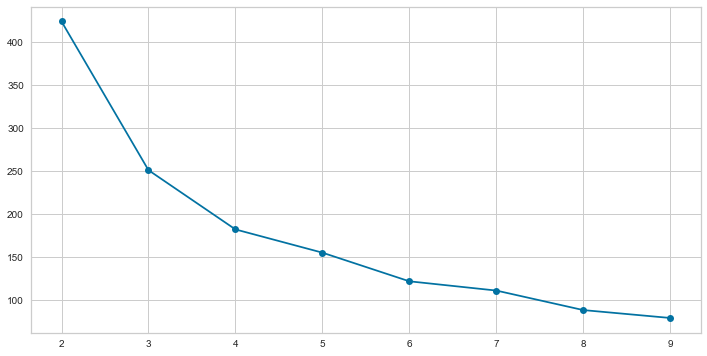

In [105]:
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [106]:
#number of clusters 4
clusters = KMeans(4, n_init = 10)
clusters.fit(data_eda_num_z)
x_pred_2=clusters.predict(data_eda_num_z)
score = silhouette_score(data_eda_num_z, clusters.labels_, metric='euclidean')
print(score)

data_clust_2=data_eda_num_z
data_clust_2['clust_group']=x_pred_2
data_41['clust_group']=x_pred_2


#Append the prediction 
print("Groups Assigned : \n")
data_41.head()

0.5024158095061623
Groups Assigned : 



Name    Runs    Ave      SR  Fours  Sixes    HF player_rank  \
1   CH Gayle 733.000 61.080 160.740 46.000 59.000 9.000           3   
3  G Gambhir 590.000 36.870 143.550 64.000 17.000 6.000           3   
5   V Sehwag 495.000 33.000 161.230 57.000 19.000 5.000           3   
7   CL White 479.000 43.540 149.680 41.000 20.000 5.000           3   
9   S Dhawan 569.000 40.640 129.610 58.000 18.000 5.000           3   

   clust_group  
1            2  
3            2  
5            2  
7            2  
9            2

In [107]:
data_41

Name    Runs    Ave      SR  Fours  Sixes    HF player_rank  \
1       CH Gayle 733.000 61.080 160.740 46.000 59.000 9.000           3   
3      G Gambhir 590.000 36.870 143.550 64.000 17.000 6.000           3   
5       V Sehwag 495.000 33.000 161.230 57.000 19.000 5.000           3   
7       CL White 479.000 43.540 149.680 41.000 20.000 5.000           3   
9       S Dhawan 569.000 40.640 129.610 58.000 18.000 5.000           3   
..           ...     ...    ...     ...    ...    ...   ...         ...   
171       Z Khan  12.000  6.000  70.580  1.000  0.000 0.000           2   
173   WD Parnell  19.000  4.750  70.370  2.000  0.000 0.000           2   
175  PC Valthaty  30.000  5.000  58.820  4.000  0.000 0.000           2   
177     RP Singh   6.000  3.000  50.000  0.000  0.000 0.000           2   
179     R Sharma   2.000  0.500  18.180  0.000  0.000 0.000           2   

     clust_group  
1              2  
3              2  
5              2  
7              2  
9              2  
..           ...  
171            3  
173            3  
175            3  
177            3  
179            3  

[90 rows x 9 columns]

In [108]:
dataClust = data_41.groupby(['clust_group'])
dataClust.mean()

Runs    Ave      SR  Fours  Sixes    HF
clust_group                                           
0           341.192 35.099 127.258 31.577 11.077 2.000
1           170.056 23.049 123.347 13.972  6.000 0.389
2           551.286 40.864 142.963 54.000 23.000 5.714
3            44.857  9.395  94.039  3.762  0.810 0.048

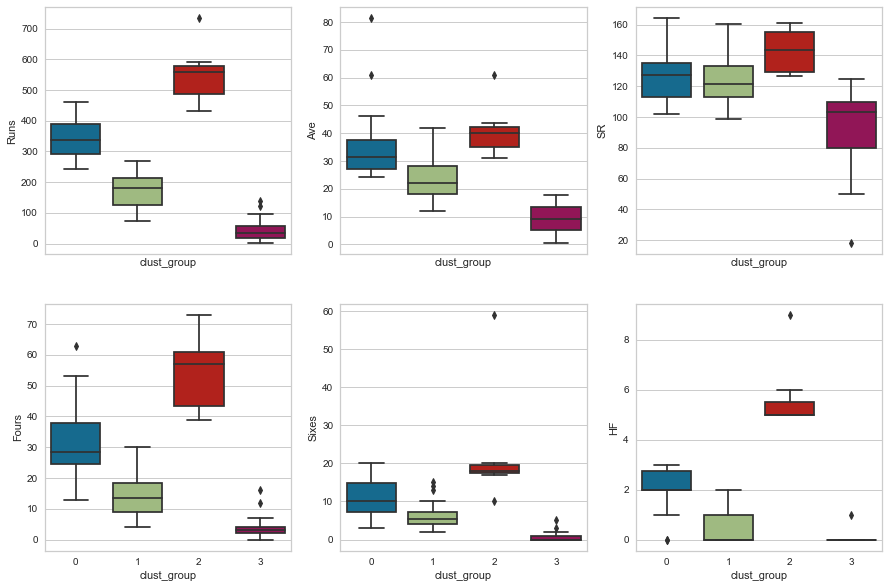

In [109]:
f, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True)
sns.boxplot(x='clust_group',y='Runs',data=data_41,ax=axes[0,0]);
sns.boxplot(x='clust_group',y='Ave',data=data_41,ax=axes[0,1]);
sns.boxplot(x='clust_group',y='SR',data=data_41,ax=axes[0,2]);
sns.boxplot(x='clust_group',y='Fours',data=data_41,ax=axes[1,0]);
sns.boxplot(x='clust_group',y='Sixes',data=data_41,ax=axes[1,1]);
sns.boxplot(x='clust_group',y='HF',data=data_41,ax=axes[1,2]);

In [110]:
data_41.loc[data_41['clust_group'] == 2, 'player_rank'] = '1'  
data_41.loc[data_41['clust_group'] == 0, 'player_rank'] = '2'
data_41.loc[data_41['clust_group'] == 1, 'player_rank'] = '3'
data_41.loc[data_41['clust_group'] == 3, 'player_rank'] = '4' 
data_41.drop(['clust_group'],axis=1,inplace=True)
data_41

Name    Runs    Ave      SR  Fours  Sixes    HF player_rank
1       CH Gayle 733.000 61.080 160.740 46.000 59.000 9.000           1
3      G Gambhir 590.000 36.870 143.550 64.000 17.000 6.000           1
5       V Sehwag 495.000 33.000 161.230 57.000 19.000 5.000           1
7       CL White 479.000 43.540 149.680 41.000 20.000 5.000           1
9       S Dhawan 569.000 40.640 129.610 58.000 18.000 5.000           1
..           ...     ...    ...     ...    ...    ...   ...         ...
171       Z Khan  12.000  6.000  70.580  1.000  0.000 0.000           4
173   WD Parnell  19.000  4.750  70.370  2.000  0.000 0.000           4
175  PC Valthaty  30.000  5.000  58.820  4.000  0.000 0.000           4
177     RP Singh   6.000  3.000  50.000  0.000  0.000 0.000           4
179     R Sharma   2.000  0.500  18.180  0.000  0.000 0.000           4

[90 rows x 8 columns]

In [111]:
datarank = data_41.groupby(['player_rank'])
datarank.mean()

Runs    Ave      SR  Fours  Sixes    HF
player_rank                                           
1           551.286 40.864 142.963 54.000 23.000 5.714
2           341.192 35.099 127.258 31.577 11.077 2.000
3           170.056 23.049 123.347 13.972  6.000 0.389
4            44.857  9.395  94.039  3.762  0.810 0.048

Using clustering players have been ranked

## PART 5:
### Questions: 
1. List down all possible dimensionality reduction techniques that can be implemented using python.

1. As more and more features get added to analysis data. This also adds to noise, multicollinearity, redundancy, more computation time and many more issues. This can be handled by dimensionality reduction techniques

1. Percent of missing data/Empty data : If a variable has a more missing datalike 80-90% then it can be dropped
2. Columns with low variance : if a feature has constant values, then it does not add to much information so such variables can be dropped
3. Highly correlated variables : variables which are correlated with each other adds to multicollinearity so columns can be dropped using Variance inflation factor
4. Random Forest Feature importance: using this method, only important variables can be selected for model and rest redundant variables can be dropped
5. Backward Feature elimination : in this algorithm, checks the model performance and removes redundant variables
6. Forward Feature selection: in this algorithm, checks the model performance and and adds important features in the model.
7. Principal component analysis (PCA) : It provides the linear combination of existing variables such that, it captures maximum variation in the data and are independent of each other
8. t-distributed stochastic neighbor embedding (t-SNE): NonLinear Dimension reduction technique
9. LDA: Linear Discriminant Analysis (LDA)
10. Autoencoder : technique used in Neural Network

2. So far you have used dimensional reduction on numeric data. Is it possible to do the same on a multimedia data [images and video] and text data ? Please illustrate your findings using a simple implementation on python.

Yes, it is possible to do dimensional reduction on Images, video and test data. To analyze image/video/text data any such data, needs to be available in vector space. So once it's available in any Matrix form techniques like dimension reductions can be applied on them.

(1797, 64)


<Figure size 576x396 with 0 Axes>

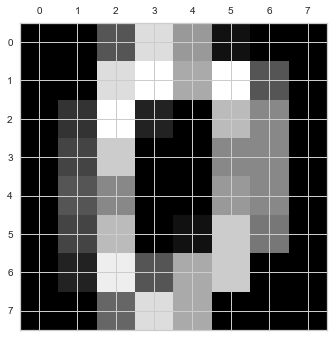

In [89]:
#mnist data
from sklearn.datasets import load_digits


digits = load_digits()
mnistdata=pd.DataFrame(digits.data, columns=digits.feature_names)
mnisttarget=pd.DataFrame(digits.target,columns={'class'})
print(digits.data.shape)


plt.gray() 
plt.matshow(digits.images[0]) 
plt.show()

In [90]:
mnistdata.head()

pixel_0_0  pixel_0_1  pixel_0_2  pixel_0_3  pixel_0_4  pixel_0_5  \
0      0.000      0.000      5.000     13.000      9.000      1.000   
1      0.000      0.000      0.000     12.000     13.000      5.000   
2      0.000      0.000      0.000      4.000     15.000     12.000   
3      0.000      0.000      7.000     15.000     13.000      1.000   
4      0.000      0.000      0.000      1.000     11.000      0.000   

   pixel_0_6  pixel_0_7  pixel_1_0  pixel_1_1  ...  pixel_6_6  pixel_6_7  \
0      0.000      0.000      0.000      0.000  ...      0.000      0.000   
1      0.000      0.000      0.000      0.000  ...      0.000      0.000   
2      0.000      0.000      0.000      0.000  ...      5.000      0.000   
3      0.000      0.000      0.000      8.000  ...      9.000      0.000   
4      0.000      0.000      0.000      0.000  ...      0.000      0.000   

   pixel_7_0  pixel_7_1  pixel_7_2  pixel_7_3  pixel_7_4  pixel_7_5  \
0      0.000      0.000      6.000     13.000     10.000      0.000   
1      0.000      0.000      0.000     11.000     16.000     10.000   
2      0.000      0.000      0.000      3.000     11.000     16.000   
3      0.000      0.000      7.000     13.000     13.000      9.000   
4      0.000      0.000      0.000      2.000     16.000      4.000   

   pixel_7_6  pixel_7_7  
0      0.000      0.000  
1      0.000      0.000  
2      9.000      0.000  
3      0.000      0.000  
4      0.000      0.000  

[5 rows x 64 columns]

In [91]:
mnisttarget.head()

class
0      0
1      1
2      2
3      3
4      4

In [92]:
#scalling data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(mnistdata)

# Apply transform to both the training set and the test set.
train_scaled = scaler.transform(mnistdata)
train_scaled

array([[ 0.        , -0.33501649, -0.04308102, ..., -1.14664746,
        -0.5056698 , -0.19600752],
       [ 0.        , -0.33501649, -1.09493684, ...,  0.54856067,
        -0.5056698 , -0.19600752],
       [ 0.        , -0.33501649, -1.09493684, ...,  1.56568555,
         1.6951369 , -0.19600752],
       ...,
       [ 0.        , -0.33501649, -0.88456568, ..., -0.12952258,
        -0.5056698 , -0.19600752],
       [ 0.        , -0.33501649, -0.67419451, ...,  0.8876023 ,
        -0.5056698 , -0.19600752],
       [ 0.        , -0.33501649,  1.00877481, ...,  0.8876023 ,
        -0.26113572, -0.19600752]])

In [93]:
from sklearn.model_selection import train_test_split
# test_size: what proportion of original data is used for test set
train_X, test_X, train_y, test_y = train_test_split(train_scaled, mnisttarget, test_size=0.30, random_state=0)

In [94]:
test_X.shape

(540, 64)

PCA analysis

In [95]:
covMatrix = np.cov(train_X,rowvar=False)
covMatrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  1.12474731,  0.60356761, ..., -0.01573136,
         0.04389344, -0.04171803],
       [ 0.        ,  0.60356761,  1.03427768, ..., -0.02137458,
         0.08836617,  0.08408676],
       ...,
       [ 0.        , -0.01573136, -0.02137458, ...,  0.98708046,
         0.63274565,  0.2538007 ],
       [ 0.        ,  0.04389344,  0.08836617, ...,  0.63274565,
         0.95251068,  0.57101872],
       [ 0.        , -0.04171803,  0.08408676, ...,  0.2538007 ,
         0.57101872,  0.88115572]])

In [96]:
#PCA
pca = PCA(n_components=0.95) # need a component to get 95% of explained variance 
pca.fit(train_X)

PCA(n_components=0.95)

In [97]:
train_img = pca.transform(train_X)
test_img = pca.transform(test_X)

In [98]:
pcs_comp=pca.components_
pcs_comp.shape

(40, 64)

In [99]:
pca_comp=pca.components_
pca_comp.shape

(40, 64)

In [100]:
pca_var=pca.explained_variance_ratio_
pca_var.shape

(40,)

In [101]:
pca_var

array([0.12550573, 0.09526257, 0.08551772, 0.0659875 , 0.05008647,
       0.0438825 , 0.03997253, 0.03338704, 0.03104718, 0.02959805,
       0.02739921, 0.02478875, 0.0242075 , 0.02186981, 0.02145429,
       0.01878447, 0.01722117, 0.01606779, 0.01551914, 0.01405863,
       0.01309939, 0.0121096 , 0.0113306 , 0.01060872, 0.00982828,
       0.00936427, 0.00852396, 0.00809449, 0.007792  , 0.00739227,
       0.00712721, 0.00667127, 0.00624478, 0.0059206 , 0.00563765,
       0.00499355, 0.00470929, 0.00445541, 0.00423559, 0.0040219 ])

Summary : 
1. This is an analysis of minst image data
2. We can see dimension reduction techniques are applicable to images too.